---
# 4. TRANSFER LEARNING

In [1]:
# Gestión y extracción de archivos
import os
import pandas as pd
import numpy as np
import random
import zipfile
import shutil
from tensorflow.keras.utils import image_dataset_from_directory

# Visualización de imágenes
from skimage import io
import matplotlib.pyplot as plt
import seaborn as sns
import json


# Red neuronal
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.densenet import DenseNet121 
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.models import Model 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Dense, Flatten, Conv2D, MaxPool2D, PReLU
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D
from tensorflow.keras.metrics import Recall
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.initializers import GlorotUniform

# Ajuste de hiperparámetros
import keras_tuner as kt
import visualkeras

# Evaluación de resultados
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report

---
## 4.1. Funciones auxiliares

En esta sección incluimos una serie de utilidades que nos servirán para gestionar tanto el proceso de entrenamiento como la evaluación de los modelos. Estas funciones nos permitirán:

- Entrenar redes neuronales con la posibilidad de activar el mecanismo de *Early Stopping* para evitar sobreajuste;
- Generar predicciones a partir de un modelo entrenado;
- Visualizar de forma clara la evolución del *loss* y la *accuracy* durante las distintas épocas de entrenamiento y validación;
- Evaluar el rendimiento del modelo utilizando métricas clásicas y una matriz de confusión interpretativa.

In [2]:
def train_model(model, bs = 128, eps = 50, early_stopping = True, pat = 3,
                min_d = 0.001):
    """
    Ejecuta el proceso de entrenamiento del modelo durante un número determinado de épocas.
    Se puede activar la parada temprana (Early Stopping) para evitar el sobreajuste.

    :param keras.engine.functional.Functional model: modelo que se desea entrenar
    :param int bs: tamaño de los batches durante el entrenamiento
    :param int eps: número máximo de épocas a ejecutar
    :param bool early_stopping: indica si se desea utilizar la técnica de Early Stopping
    :param int pat: número de épocas consecutivas sin mejora permitidas antes de detener el entrenamiento
    :param float min_d: mejora mínima en la función de pérdida para ser considerada significativa
    """
    
    early_stop = None

    if early_stopping == True:
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=pat,
            min_delta=min_d,
            restore_best_weights=True,
            verbose=1
        )

        history = model.fit(
            train_set,
            epochs=eps,
            validation_data=val_set,
            batch_size=bs,
            class_weight=CLASS_WEIGHTS,
            callbacks=[early_stop],
            verbose=1
        )
    
    else:
        history = model.fit(
            train_set,
            epochs=eps,
            validation_data=val_set,
            batch_size=bs,
            class_weight=CLASS_WEIGHTS,
            verbose=1
        )

    return history, early_stop

In [3]:
def plot_history(history, early_stop=None, plot_size=(15, 5)):
    """
    Muestra información útil sobre el entrenamiento del modelo, incluyendo:
    - Detalles básicos como el número total de épocas y la mejor época alcanzada;
    - Dos gráficos que permiten analizar cómo evolucionaron la función de pérdida (loss) 
      y la precisión (accuracy) tanto en entrenamiento como en validación.

    :param keras.callbacks.History history: objeto que guarda los valores de loss y accuracy por época
    :param keras.callbacks.EarlyStopping early_stop: callback de early stopping usado durante el entrenamiento
    :param tuple plot_size: tamaño de la figura que se va a mostrar
    """

    if early_stop is not None:
        if early_stop.stopped_epoch != 0:
            epochs = early_stop.stopped_epoch + 1
        else:
            early_stop.best_epoch + 1
        best_epoch = early_stop.best_epoch + 1
    else:
        epochs = len(history.epoch)
        best_epoch = epochs

    fig = plt.figure(figsize=plot_size)

    # Gráfico de evolución de la pérdida
    plt.subplot(1, 2, 1)
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.title('Evolución de la pérdida')
    plt.xticks(np.arange(len(history.epoch)), np.arange(1, len(history.epoch)+1))
    plt.plot(range(0, best_epoch), history.history['loss'][:best_epoch], '.-', color="C0")
    plt.plot(range(0, best_epoch), history.history['val_loss'][:best_epoch], '.-', color="C1")
    plt.plot(range(best_epoch-1, len(history.epoch)), history.history['loss'][best_epoch-1:], '.--', color="C0")
    plt.plot(range(best_epoch-1, len(history.epoch)), history.history['val_loss'][best_epoch-1:], '.--', color="C1")
    plt.legend(['Entrenamiento', 'Validación'])

    # Gráfico de evolución de la precisión
    plt.subplot(1, 2, 2)
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.title('Evolución de la precisión')
    plt.xticks(np.arange(len(history.epoch)), np.arange(1, len(history.epoch)+1))
    plt.plot(range(0, best_epoch), history.history['accuracy'][:best_epoch], '.-', color="C0")
    plt.plot(range(0, best_epoch), history.history['val_accuracy'][:best_epoch], '.-', color="C1")
    plt.plot(range(best_epoch-1, len(history.epoch)), history.history['accuracy'][best_epoch-1:], '.--', color="C0")
    plt.plot(range(best_epoch-1, len(history.epoch)), history.history['val_accuracy'][best_epoch-1:], '.--', color="C1")
    plt.legend(['Entrenamiento', 'Validación'], loc='lower right')

    # Resumen de resultados
    print('Resumen del entrenamiento:\n')
    print('Número total de épocas:', epochs)
    print('Época con mejor resultado (weights restaurados):', best_epoch)
    print('Accuracy en entrenamiento (época ' + str(best_epoch) + '): ' + str(history.history['accuracy'][best_epoch - 1]))
    print('Accuracy en validación (época ' + str(best_epoch) + '): ' + str(history.history['val_accuracy'][best_epoch - 1]))
    print('Loss en entrenamiento (época ' + str(best_epoch) + '): ' + str(history.history['loss'][best_epoch - 1]))
    
    index = history.history['val_loss'].index(min(history.history['val_loss']))
    print('Loss en validación (época ' + str(best_epoch) + '): ' + str(history.history['val_loss'][index]))
    print('\n\n')

In [4]:
def make_prediction(model, test_set):
    """
    Genera las predicciones del modelo sobre el conjunto de prueba.

    :param keras.engine.functional.Functional model: modelo entrenado que se utiliza para hacer la clasificación
    :param BatchDataset test_set: conjunto de datos de prueba sobre el que se realizarán las predicciones
    :return: array con las clases predichas para cada imagen del conjunto de prueba
    """
    y_prediction = model.predict(test_set)
    y_pred = []
    for i in range(len(y_prediction)):
        y_pred.append(np.argmax(y_prediction[i]))
    y_pred = np.array(y_pred)

    return y_pred

In [5]:
def evaluate_prediction(model, y_test, y_pred, labels, plot_size=(15, 15)):
    """
    Calcula e interpreta las métricas de evaluación de un modelo de clasificación, 
    mostrando el informe de clasificación y la matriz de confusión en forma gráfica.

    :param keras.engine.functional.Functional model: modelo de Keras previamente entrenado
    :param array y_test: etiquetas reales del conjunto de prueba
    :param array y_pred: etiquetas predichas por el modelo
    :param list labels: lista con los nombres de las clases (pintores en este caso)
    :param tuple plot_size: tamaño de la figura de la matriz de confusión
    """
    # Informe de clasificación
    cl = classification_report(y_test, y_pred, target_names=labels)
    print('\nInforme de clasificación\n', cl)

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)

    fig, ax = plt.subplots(figsize=plot_size)
    sns.heatmap(cm, annot=True, fmt='g', cmap="PuRd")
    ax.set_title('Matriz de confusión')
    ax.set_xlabel('Etiquetas predichas')
    ax.set_ylabel('Etiquetas reales')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.xticks(rotation='vertical')
    plt.yticks(rotation='horizontal')

---
## 4.2. FINE-TUNING

---
### 4.2.1. Carga de datos

Como ya se hizo en el notebook de EDA, vamos a definir una función para cargar las imágenes del dataset de forma estructurada. Durante la carga, las imágenes se redimensionan a un tamaño uniforme de **224×224 píxeles**, lo que facilita su procesamiento posterior por las redes neuronales.  
Los datos se agrupan en *batches* de tamaño **64**, y se reserva un **10%** del conjunto de entrenamiento para validación mediante el parámetro `validation_split`.

In [6]:
def import_data(train_path, test_path, img_size=(224, 224), batch_size=64,
                val_split=0.1):
    """
    Importa las imágenes para los conjuntos de entrenamiento, validación y prueba
    utilizando la función image_dataset_from_directory de Keras.

    :param tuple img_size: tamaño al que se redimensionarán las imágenes
    :param int batch_size: tamaño de los lotes (batches) para los conjuntos
    :param float val_split: proporción del conjunto de entrenamiento reservada para validación
    :param str train_path: ruta de la carpeta que contiene las imágenes de entrenamiento
    :param str test_path: ruta de la carpeta que contiene las imágenes de prueba
    """
    
    print('=========== CONJUNTO DE TRAINING ===========')
    train_set = keras.preprocessing.image_dataset_from_directory(
        train_path,
        image_size=img_size,
        color_mode='rgb',
        batch_size=batch_size,
        label_mode='categorical',
        shuffle=True,
        validation_split=val_split,
        subset='training',
        seed=1)

    print('\n\n=========== CONJUNTO DE VALIDACIÓN ===========')
    val_set = keras.preprocessing.image_dataset_from_directory(
        train_path,
        image_size=img_size,
        color_mode='rgb',
        batch_size=batch_size,
        label_mode='categorical',
        shuffle=True,
        validation_split=val_split,
        subset='validation',
        seed=1)

    print('\n\n=========== CONJUNTO DE TEST ===========')
    test_set = keras.preprocessing.image_dataset_from_directory(
        test_path,
        image_size=img_size,
        color_mode='rgb',
        batch_size=batch_size,
        label_mode='categorical',
        shuffle=False,
        seed=1)

    return train_set, val_set, test_set

In [7]:
train_set, val_set, test_set = import_data(train_path = "data/" + "Train",
                                           test_path = "data/" + "Test")

=========== CONJUNTO DE TRAINING ===========
Found 3178 files belonging to 10 classes.
Using 2861 files for training.


=========== CONJUNTO DE VALIDACIÓN ===========
Found 3178 files belonging to 10 classes.
Using 317 files for validation.


2025-05-05 01:01:00.062276: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-05-05 01:01:00.062475: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-05 01:01:00.062488: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-05 01:01:00.062506: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-05 01:01:00.062518: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)




=========== CONJUNTO DE TEST ===========
Found 793 files belonging to 10 classes.


In [8]:
# Inspección de las dimensiones de los elementos del dataset
train_set.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))

In [9]:
# Extracción de las etiquetas  del conjunto de test
y_test = np.concatenate([y for x, y in test_set], axis=0)
y_test = [np.argmax(l) for l in y_test]

2025-05-05 01:01:04.906146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
INPUT_SHAPE = (224,224,3)
NUM_CLASSES = 10

---
### 4.2.2. Visualización del contenido del dataset

A continuación se muestra una visualización de 9 pinturas seleccionadas aleatoriamente del dataset.  
Como se puede observar, las imágenes fueron redimensionadas y ahora todas tienen el mismo tamaño: **224 × 224 píxeles**.

2025-05-05 01:01:08.528131: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


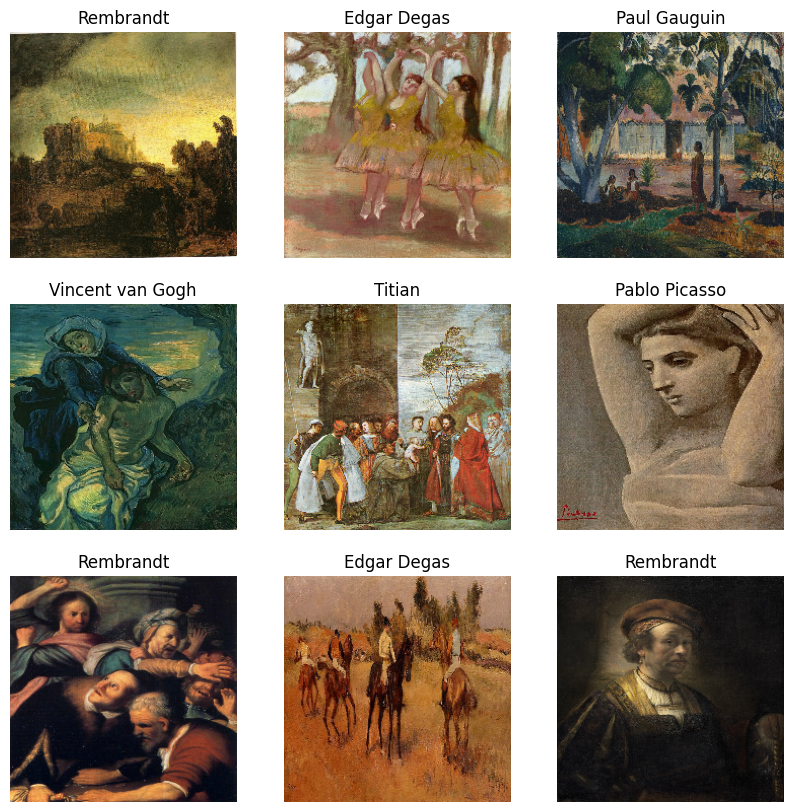

In [11]:
class_names = train_set.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):  # Solo 1 batch para mostrar 9 imágenes
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        # Obtener índice del pintor
        author_index = tf.argmax(labels[i]).numpy()
        author = class_names[author_index].split('_')

        # Reconstruir nombre del pintor
        title = ' '.join(author)
        plt.title(title)
        plt.axis("off")

In [12]:
INPUT_SHAPE = (224,224,3)
NUM_CLASSES = 10
num_classes = NUM_CLASSES

Cargamos los pesos que hallamos en el notebook 1.- EDA

In [13]:
with open('class_weights.json', 'r', encoding='utf-8') as f:
    raw = json.load(f)

# Convierte las claves de str a int
CLASS_WEIGHTS = {int(k): v for k, v in raw.items()}
CLASS_WEIGHTS


{0: 0.44548044548044546,
 1: 0.556454221934649,
 2: 0.8909608909608909,
 3: 1.1625549172017573,
 4: 1.193615544760583,
 5: 1.2559328221978825,
 6: 1.3421771361685524,
 7: 1.4891774891774892,
 8: 1.5107597716293368,
 9: 1.5329768270944741,
 10: 1.6373155640171346}

---
### 4.2.3. <b> MobileNetV2 </b>
El primer modelo que se ha considerado es **MobileNetV2**, una red ligera de tan solo 14 MB, con bajo número de parámetros.  
Una vez importado el modelo base con los pesos previamente entrenados en el conjunto de datos *ImageNet*, se elimina la capa densa final para reemplazarla por una serie de capas adaptadas específicamente a la tarea actual.

In [14]:
# Importamos MobileNetV2
base_model_mn = MobileNetV2(weights = 'imagenet')

# Eliminación de la última capa densa
base_model_mn = Model(inputs = base_model_mn.input, 
                      outputs = base_model_mn.get_layer('global_average_pooling2d').output)

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Una vez recortado el modelo base, se define una función que permite adaptarlo al problema específico añadiendo nuevas capas. Entre ellas se incluye una capa de entrada (*Input*) con una forma establecida de $(224, 224, 3)$.

In [17]:
def mobilenet_tuning(base_model, lr, augmentation=False): 
    """
    Esta función realiza el fine-tuning y personalización de la arquitectura MobileNetV2.
    
    :param base_model: modelo base preentrenado que se tomará como punto de partida
    :param float lr: tasa de aprendizaje para el optimizador
    :param bool augmentation: indica si se desea aplicar técnicas de aumento de datos
    """
    # Limpiar la sesión actual de Keras
    keras.backend.clear_session()

    # Congelar los pesos de las capas del modelo base para evitar su actualización
    for layer in base_model.layers:
        layer.trainable = False

    # Capa de entrada
    inputs = keras.Input(shape=INPUT_SHAPE)
    x = inputs

    # Aplicación opcional de técnicas de Data Augmentation
    if augmentation == True:
        x = keras.layers.RandomRotation(0.4, fill_mode='nearest')(x)
        x = keras.layers.RandomFlip('horizontal')(x)
        x = keras.layers.RandomFlip('vertical')(x)
        x = keras.layers.RandomContrast(0.1)(x)
        x = keras.layers.RandomZoom(0.5)(x)

    # Preprocesamiento específico para MobileNetV2
    x = keras.applications.mobilenet_v2.preprocess_input(x)
    x = base_model(x)

    # Añadir nuevas capas densas personalizadas para ajustar al problema
    x = keras.layers.Dense(128, activation='relu')(x) 
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(64, activation='relu')(x) 
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.Dense(32, activation='relu')(x) 
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

    # Definición del modelo completo
    outputs = x
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compilación del modelo con optimizador Adam y pérdida para clasificación multiclase
    model.compile(optimizer=Adam(lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [18]:
model_mn = mobilenet_tuning(base_model_mn, lr = 0.001) 
model_mn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ (None, 1280)           │     2,257,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,432,618 (9.28 MB)

 Trainable params: 174,634 (682.16 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [19]:
# Training
history_mn, early_stopping = train_model(model_mn, bs = 64, eps = 50, early_stopping = True, pat = 5)

Epoch 1/50


2025-05-05 01:01:45.519858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


28/45 ━━━━━━━━━━━━━━━━━━━━ 4s 239ms/step - accuracy: 0.1208 - loss: 7.9702

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 341ms/step - accuracy: 0.1245 - loss: 9.3747 - val_accuracy: 0.2461 - val_loss: 5.0235
Epoch 2/50
29/45 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - accuracy: 0.1634 - loss: 15.0830

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 274ms/step - accuracy: 0.1620 - loss: 15.2227 - val_accuracy: 0.3060 - val_loss: 4.2101
Epoch 3/50
31/45 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.1509 - loss: 16.4123

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 255ms/step - accuracy: 0.1539 - loss: 16.4237 - val_accuracy: 0.3186 - val_loss: 3.6726
Epoch 4/50
35/45 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - accuracy: 0.1831 - loss: 15.7707

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 270ms/step - accuracy: 0.1846 - loss: 15.5463 - val_accuracy: 0.3975 - val_loss: 3.2468
Epoch 5/50
28/45 ━━━━━━━━━━━━━━━━━━━━ 4s 248ms/step - accuracy: 0.2261 - loss: 11.9142

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 296ms/step - accuracy: 0.2276 - loss: 11.7694 - val_accuracy: 0.4101 - val_loss: 3.8735
Epoch 6/50
31/45 ━━━━━━━━━━━━━━━━━━━━ 3s 276ms/step - accuracy: 0.2692 - loss: 10.4670

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 304ms/step - accuracy: 0.2720 - loss: 10.3972 - val_accuracy: 0.4574 - val_loss: 3.3261
Epoch 7/50
29/45 ━━━━━━━━━━━━━━━━━━━━ 4s 254ms/step - accuracy: 0.2743 - loss: 10.4415

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 269ms/step - accuracy: 0.2798 - loss: 10.3233 - val_accuracy: 0.5237 - val_loss: 2.6272
Epoch 8/50
31/45 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - accuracy: 0.3136 - loss: 8.8454

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 249ms/step - accuracy: 0.3149 - loss: 8.7553 - val_accuracy: 0.5174 - val_loss: 2.6066
Epoch 9/50
35/45 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.3471 - loss: 7.2429

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 245ms/step - accuracy: 0.3490 - loss: 7.1594 - val_accuracy: 0.4984 - val_loss: 2.6138
Epoch 10/50
29/45 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - accuracy: 0.3471 - loss: 6.0945

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 246ms/step - accuracy: 0.3489 - loss: 6.0177 - val_accuracy: 0.5394 - val_loss: 2.2284
Epoch 11/50
29/45 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accuracy: 0.3547 - loss: 5.5922

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 242ms/step - accuracy: 0.3593 - loss: 5.4676 - val_accuracy: 0.5047 - val_loss: 2.5031
Epoch 12/50
31/45 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - accuracy: 0.3815 - loss: 4.6415

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 245ms/step - accuracy: 0.3838 - loss: 4.5915 - val_accuracy: 0.5363 - val_loss: 2.1296
Epoch 13/50
29/45 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - accuracy: 0.3985 - loss: 4.2220

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 242ms/step - accuracy: 0.4065 - loss: 4.0996 - val_accuracy: 0.5047 - val_loss: 2.0424
Epoch 14/50
29/45 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - accuracy: 0.4094 - loss: 3.4183

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 241ms/step - accuracy: 0.4175 - loss: 3.3116 - val_accuracy: 0.5615 - val_loss: 1.6250
Epoch 15/50
36/45 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - accuracy: 0.4260 - loss: 2.9371

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 248ms/step - accuracy: 0.4278 - loss: 2.8950 - val_accuracy: 0.5394 - val_loss: 1.5808
Epoch 16/50
31/45 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.4429 - loss: 2.4618

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 274ms/step - accuracy: 0.4434 - loss: 2.4345 - val_accuracy: 0.5710 - val_loss: 1.3668
Epoch 17/50
35/45 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.4604 - loss: 2.1505

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 263ms/step - accuracy: 0.4618 - loss: 2.1485 - val_accuracy: 0.5552 - val_loss: 1.3081
Epoch 18/50
35/45 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.4646 - loss: 2.1099

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 254ms/step - accuracy: 0.4677 - loss: 2.0639 - val_accuracy: 0.5426 - val_loss: 1.3732
Epoch 19/50
36/45 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - accuracy: 0.4979 - loss: 1.6985

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 261ms/step - accuracy: 0.4971 - loss: 1.7001 - val_accuracy: 0.5363 - val_loss: 1.2934
Epoch 20/50
37/45 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - accuracy: 0.4772 - loss: 1.7550

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 255ms/step - accuracy: 0.4790 - loss: 1.7437 - val_accuracy: 0.5741 - val_loss: 1.2449
Epoch 21/50
34/45 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.4765 - loss: 1.6612

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 253ms/step - accuracy: 0.4781 - loss: 1.6620 - val_accuracy: 0.5489 - val_loss: 1.2412
Epoch 22/50
29/45 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.5007 - loss: 1.4673

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 257ms/step - accuracy: 0.4975 - loss: 1.4802 - val_accuracy: 0.5899 - val_loss: 1.1802
Epoch 23/50
32/45 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.5042 - loss: 1.5109

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 253ms/step - accuracy: 0.5023 - loss: 1.5114 - val_accuracy: 0.5584 - val_loss: 1.2145
Epoch 24/50
36/45 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - accuracy: 0.4938 - loss: 1.4982

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 252ms/step - accuracy: 0.4957 - loss: 1.4854 - val_accuracy: 0.5741 - val_loss: 1.1932
Epoch 25/50
31/45 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.5089 - loss: 1.4643

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 253ms/step - accuracy: 0.5122 - loss: 1.4479 - val_accuracy: 0.5868 - val_loss: 1.1799
Epoch 26/50
35/45 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.5211 - loss: 1.3894

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 257ms/step - accuracy: 0.5187 - loss: 1.3892 - val_accuracy: 0.5804 - val_loss: 1.1631
Epoch 27/50
29/45 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - accuracy: 0.5120 - loss: 1.4023

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 253ms/step - accuracy: 0.5147 - loss: 1.4012 - val_accuracy: 0.5615 - val_loss: 1.1687
Epoch 28/50
29/45 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - accuracy: 0.5075 - loss: 1.3590

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 251ms/step - accuracy: 0.5128 - loss: 1.3559 - val_accuracy: 0.5584 - val_loss: 1.1990
Epoch 29/50
30/45 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.5438 - loss: 1.3026

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 251ms/step - accuracy: 0.5442 - loss: 1.3070 - val_accuracy: 0.5741 - val_loss: 1.1877
Epoch 30/50
29/45 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.5384 - loss: 1.3057

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 253ms/step - accuracy: 0.5422 - loss: 1.2938 - val_accuracy: 0.5426 - val_loss: 1.1892
Epoch 31/50
34/45 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.5354 - loss: 1.3016

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 255ms/step - accuracy: 0.5401 - loss: 1.2865 - val_accuracy: 0.5868 - val_loss: 1.1667
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 26.


Resumen del entrenamiento:

Número total de épocas: 31
Época con mejor resultado (weights restaurados): 26
Accuracy en entrenamiento (época 26): 0.508912980556488
Accuracy en validación (época 26): 0.5804416537284851
Loss en entrenamiento (época 26): 1.3979860544204712
Loss en validación (época 26): 1.1631344556808472





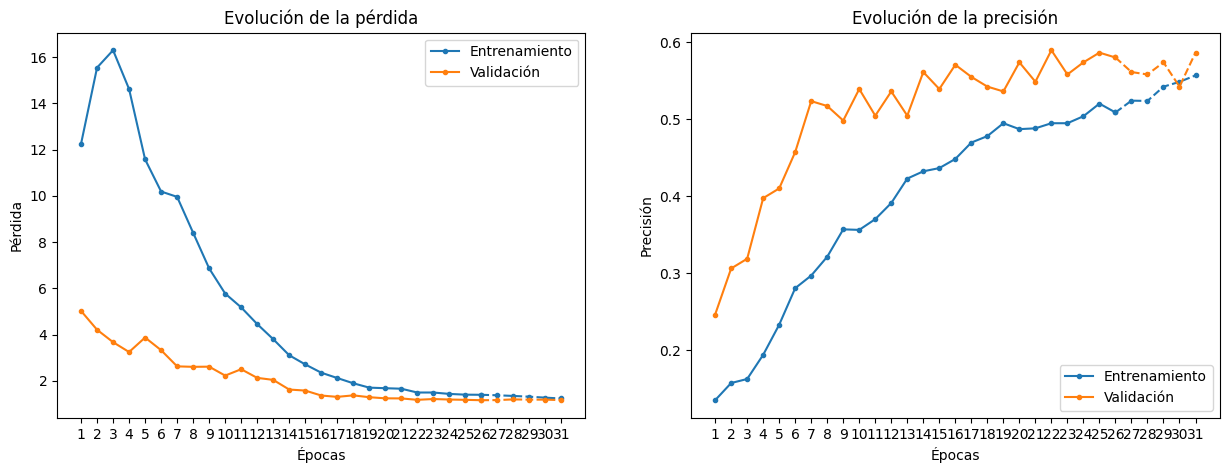

In [20]:
plot_history(history_mn, early_stop = early_stopping)

Lo primero que apreciamos es que no tenemos sobreajuste, pues en la gráfica de pérdida vemos como la curva de validación se mantiene por debajo de la de entrenamiento. Este mismo comportamiento se puede desprender  de la curva de precisión, donde en este caso la curva de validación queda siempre por encima de la de entrenamiento. Sin embargo, el *accuracy* que estamos obteniendo no es satisfactorio (el máximo alcanzado en validación es del 58%).

In [21]:
y_pred = make_prediction(model_mn, test_set)

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 345ms/step



Informe de clasificación
                        precision    recall  f1-score   support

        Alfred_Sisley       0.71      0.23      0.35        52
          Edgar_Degas       0.63      0.69      0.66       140
       Francisco_Goya       0.35      0.19      0.25        58
         Marc_Chagall       0.44      0.46      0.45        48
        Pablo_Picasso       0.68      0.60      0.64        88
         Paul_Gauguin       0.36      0.13      0.19        62
Pierre-Auguste_Renoir       0.71      0.72      0.71        67
            Rembrandt       0.73      0.88      0.80        52
               Titian       0.77      0.86      0.81        51
     Vincent_van_Gogh       0.60      0.87      0.71       175

             accuracy                           0.62       793
            macro avg       0.60      0.56      0.56       793
         weighted avg       0.60      0.62      0.59       793



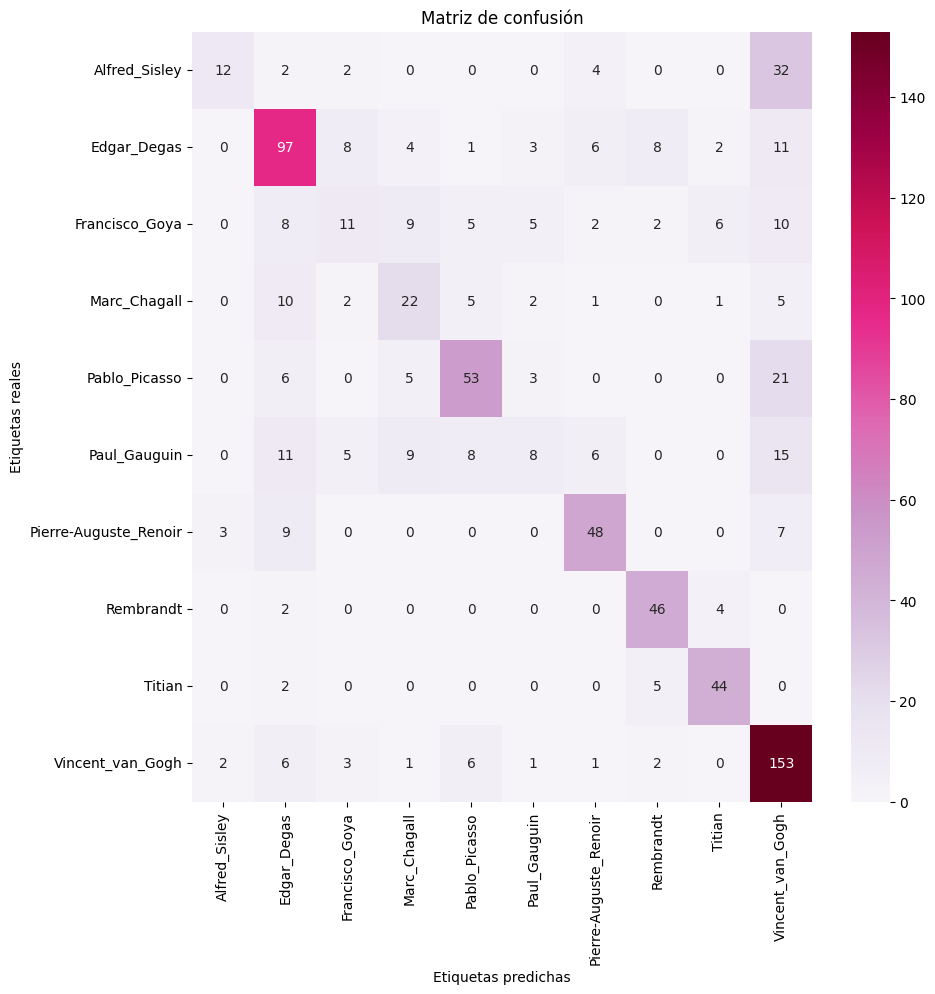

In [25]:
labels = train_set.class_names
evaluate_prediction(model_mn, y_test, y_pred, labels, plot_size=(10,10)) 

Dado el bajo nivel de precisión alcanzado, el modelo comete numerosos errores de clasificación. En particular, muchas de las imágenes pertenecientes a la clase 'Alfred Sisley' son etiquetadas de forma incorrecta. Además, se observa que en muchos de estos casos erróneos, las predicciones tienden a asignar las imágenes a la clase 'Vincent Van Gogh', que es la que cuenta con el mayor número de ejemplos en el conjunto de datos.

In [24]:
model_mn.save('mn.h5')

---
### 4.2.4. <b> MobileNetV2 </b> con Data Augmentation
Dado que el entrenamiento del modelo presentaba un bajo accuracy, vamos a aplicar la técnica de **Data Augmentation**. Esta estrategia permite ampliar la variedad y cantidad del conjunto de entrenamiento, aplicando transformaciones aleatorias pero plausibles sobre las imágenes, como puede ser una rotación.

En concreto, se utilizaron los siguientes tipos de capas para realizar esta ampliación de datos:
- `RandomRotation`;
- `RandomFlip` en orientación *horizontal* y *vertical*;
- `RandomContrast`;
- `RandomZoom`.

El modelo base se mantiene igual, siendo la única diferencia la incorporación de estas capas justo después de la capa de entrada. Se probaron múltiples combinaciones de estas transformaciones junto con distintos valores para sus parámetros, seleccionando finalmente aquella configuración que ofrecía los mejores resultados.

In [57]:
model_mn_aug = mobilenet_tuning(base_model_mn, lr = 0.001, augmentation = True)
model_mn_aug.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 224, 224, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ (None, 1280)           │     2,257,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,432,618 (9.28 MB)

 Trainable params: 174,634 (682.16 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [58]:
# Entrenamiento
history_mn_aug, early_stopping_aug = train_model(model_mn_aug, bs = 64, eps = 50, early_stopping = True, pat = 5)

Epoch 1/50
30/45 ━━━━━━━━━━━━━━━━━━━━ 5s 347ms/step - accuracy: 0.1334 - loss: 9.3546

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 31s 501ms/step - accuracy: 0.1357 - loss: 10.9744 - val_accuracy: 0.2555 - val_loss: 6.5507
Epoch 2/50
30/45 ━━━━━━━━━━━━━━━━━━━━ 4s 328ms/step - accuracy: 0.1407 - loss: 19.5928

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 357ms/step - accuracy: 0.1449 - loss: 19.4337 - val_accuracy: 0.2555 - val_loss: 8.0493
Epoch 3/50
31/45 ━━━━━━━━━━━━━━━━━━━━ 4s 342ms/step - accuracy: 0.1698 - loss: 19.6816

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 385ms/step - accuracy: 0.1695 - loss: 19.3179 - val_accuracy: 0.2902 - val_loss: 6.4621
Epoch 4/50
35/45 ━━━━━━━━━━━━━━━━━━━━ 3s 387ms/step - accuracy: 0.1803 - loss: 16.4949

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 435ms/step - accuracy: 0.1819 - loss: 16.4628 - val_accuracy: 0.3028 - val_loss: 6.0533
Epoch 5/50
35/45 ━━━━━━━━━━━━━━━━━━━━ 3s 337ms/step - accuracy: 0.2028 - loss: 16.1231

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 363ms/step - accuracy: 0.2023 - loss: 16.0029 - val_accuracy: 0.3312 - val_loss: 4.6974
Epoch 6/50
32/45 ━━━━━━━━━━━━━━━━━━━━ 4s 371ms/step - accuracy: 0.1903 - loss: 14.0671

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 403ms/step - accuracy: 0.1913 - loss: 13.7459 - val_accuracy: 0.3470 - val_loss: 4.4392
Epoch 7/50
36/45 ━━━━━━━━━━━━━━━━━━━━ 3s 384ms/step - accuracy: 0.1967 - loss: 12.3383

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 403ms/step - accuracy: 0.2027 - loss: 12.1838 - val_accuracy: 0.3533 - val_loss: 3.5384
Epoch 8/50
32/45 ━━━━━━━━━━━━━━━━━━━━ 4s 341ms/step - accuracy: 0.2261 - loss: 10.1038

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 365ms/step - accuracy: 0.2298 - loss: 9.9232 - val_accuracy: 0.4416 - val_loss: 2.8947
Epoch 9/50
35/45 ━━━━━━━━━━━━━━━━━━━━ 3s 343ms/step - accuracy: 0.2353 - loss: 8.8412

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 363ms/step - accuracy: 0.2372 - loss: 8.8312 - val_accuracy: 0.4543 - val_loss: 2.9446
Epoch 10/50
31/45 ━━━━━━━━━━━━━━━━━━━━ 4s 344ms/step - accuracy: 0.2552 - loss: 7.6666

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 372ms/step - accuracy: 0.2535 - loss: 7.6522 - val_accuracy: 0.4669 - val_loss: 2.5910
Epoch 11/50
30/45 ━━━━━━━━━━━━━━━━━━━━ 5s 339ms/step - accuracy: 0.2437 - loss: 6.8465

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 361ms/step - accuracy: 0.2471 - loss: 6.6943 - val_accuracy: 0.4259 - val_loss: 2.3910
Epoch 12/50
34/45 ━━━━━━━━━━━━━━━━━━━━ 3s 330ms/step - accuracy: 0.2600 - loss: 5.7951

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 356ms/step - accuracy: 0.2576 - loss: 5.7660 - val_accuracy: 0.4069 - val_loss: 2.2418
Epoch 13/50
34/45 ━━━━━━━━━━━━━━━━━━━━ 3s 326ms/step - accuracy: 0.2621 - loss: 4.9490

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 355ms/step - accuracy: 0.2635 - loss: 4.9051 - val_accuracy: 0.4196 - val_loss: 2.0091
Epoch 14/50
34/45 ━━━━━━━━━━━━━━━━━━━━ 3s 339ms/step - accuracy: 0.2389 - loss: 4.2580

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 364ms/step - accuracy: 0.2439 - loss: 4.1716 - val_accuracy: 0.4006 - val_loss: 1.9305
Epoch 15/50
35/45 ━━━━━━━━━━━━━━━━━━━━ 3s 330ms/step - accuracy: 0.2758 - loss: 3.3351

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 355ms/step - accuracy: 0.2764 - loss: 3.3168 - val_accuracy: 0.4227 - val_loss: 1.7351
Epoch 16/50
30/45 ━━━━━━━━━━━━━━━━━━━━ 4s 333ms/step - accuracy: 0.2937 - loss: 2.9794

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 356ms/step - accuracy: 0.2895 - loss: 2.9426 - val_accuracy: 0.4132 - val_loss: 1.6435
Epoch 17/50
34/45 ━━━━━━━━━━━━━━━━━━━━ 3s 350ms/step - accuracy: 0.2876 - loss: 2.6408

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 369ms/step - accuracy: 0.2960 - loss: 2.5924 - val_accuracy: 0.4322 - val_loss: 1.6460
Epoch 18/50
34/45 ━━━━━━━━━━━━━━━━━━━━ 3s 333ms/step - accuracy: 0.2990 - loss: 2.3953

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 364ms/step - accuracy: 0.3027 - loss: 2.3795 - val_accuracy: 0.3943 - val_loss: 1.6616
Epoch 19/50
36/45 ━━━━━━━━━━━━━━━━━━━━ 3s 339ms/step - accuracy: 0.2873 - loss: 2.2679

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 363ms/step - accuracy: 0.2931 - loss: 2.2505 - val_accuracy: 0.4322 - val_loss: 1.6657
Epoch 20/50
34/45 ━━━━━━━━━━━━━━━━━━━━ 3s 356ms/step - accuracy: 0.3039 - loss: 2.2108

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 374ms/step - accuracy: 0.3102 - loss: 2.1957 - val_accuracy: 0.4921 - val_loss: 1.6191
Epoch 21/50
34/45 ━━━━━━━━━━━━━━━━━━━━ 3s 354ms/step - accuracy: 0.3151 - loss: 2.1142

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 376ms/step - accuracy: 0.3202 - loss: 2.1107 - val_accuracy: 0.4479 - val_loss: 1.5998
Epoch 22/50
27/45 ━━━━━━━━━━━━━━━━━━━━ 6s 345ms/step - accuracy: 0.3242 - loss: 2.0838

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 360ms/step - accuracy: 0.3322 - loss: 2.0711 - val_accuracy: 0.4543 - val_loss: 1.5695
Epoch 23/50
31/45 ━━━━━━━━━━━━━━━━━━━━ 4s 330ms/step - accuracy: 0.3250 - loss: 2.0163

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 351ms/step - accuracy: 0.3336 - loss: 2.0019 - val_accuracy: 0.5110 - val_loss: 1.5385
Epoch 24/50
32/45 ━━━━━━━━━━━━━━━━━━━━ 4s 324ms/step - accuracy: 0.3590 - loss: 1.9499

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 350ms/step - accuracy: 0.3599 - loss: 1.9479 - val_accuracy: 0.4826 - val_loss: 1.5097
Epoch 25/50
29/45 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - accuracy: 0.3553 - loss: 1.8853

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 355ms/step - accuracy: 0.3626 - loss: 1.8789 - val_accuracy: 0.5016 - val_loss: 1.5092
Epoch 26/50
32/45 ━━━━━━━━━━━━━━━━━━━━ 4s 341ms/step - accuracy: 0.3626 - loss: 1.9116

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 363ms/step - accuracy: 0.3681 - loss: 1.8988 - val_accuracy: 0.4826 - val_loss: 1.4708
Epoch 27/50
37/45 ━━━━━━━━━━━━━━━━━━━━ 2s 325ms/step - accuracy: 0.3567 - loss: 1.8569

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 350ms/step - accuracy: 0.3629 - loss: 1.8490 - val_accuracy: 0.4890 - val_loss: 1.4620
Epoch 28/50
35/45 ━━━━━━━━━━━━━━━━━━━━ 3s 335ms/step - accuracy: 0.3642 - loss: 1.8326

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 366ms/step - accuracy: 0.3718 - loss: 1.8241 - val_accuracy: 0.5268 - val_loss: 1.4127
Epoch 29/50
36/45 ━━━━━━━━━━━━━━━━━━━━ 3s 340ms/step - accuracy: 0.4179 - loss: 1.7841

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 357ms/step - accuracy: 0.4148 - loss: 1.7830 - val_accuracy: 0.5174 - val_loss: 1.4222
Epoch 30/50
33/45 ━━━━━━━━━━━━━━━━━━━━ 3s 327ms/step - accuracy: 0.4071 - loss: 1.7630

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 346ms/step - accuracy: 0.4073 - loss: 1.7543 - val_accuracy: 0.5142 - val_loss: 1.4161
Epoch 31/50
35/45 ━━━━━━━━━━━━━━━━━━━━ 3s 324ms/step - accuracy: 0.3940 - loss: 1.7581

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 347ms/step - accuracy: 0.3991 - loss: 1.7504 - val_accuracy: 0.5268 - val_loss: 1.3641
Epoch 32/50
33/45 ━━━━━━━━━━━━━━━━━━━━ 3s 326ms/step - accuracy: 0.4001 - loss: 1.7565

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 349ms/step - accuracy: 0.4088 - loss: 1.7396 - val_accuracy: 0.5457 - val_loss: 1.3228
Epoch 33/50
36/45 ━━━━━━━━━━━━━━━━━━━━ 2s 328ms/step - accuracy: 0.4410 - loss: 1.6969

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 350ms/step - accuracy: 0.4394 - loss: 1.6933 - val_accuracy: 0.5268 - val_loss: 1.3535
Epoch 34/50
37/45 ━━━━━━━━━━━━━━━━━━━━ 2s 328ms/step - accuracy: 0.4360 - loss: 1.6872

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 349ms/step - accuracy: 0.4366 - loss: 1.6809 - val_accuracy: 0.5394 - val_loss: 1.3392
Epoch 35/50
37/45 ━━━━━━━━━━━━━━━━━━━━ 2s 333ms/step - accuracy: 0.4099 - loss: 1.6721

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 354ms/step - accuracy: 0.4135 - loss: 1.6672 - val_accuracy: 0.5457 - val_loss: 1.3194
Epoch 36/50
30/45 ━━━━━━━━━━━━━━━━━━━━ 4s 327ms/step - accuracy: 0.4384 - loss: 1.6216

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 355ms/step - accuracy: 0.4374 - loss: 1.6261 - val_accuracy: 0.5615 - val_loss: 1.3162
Epoch 37/50
30/45 ━━━━━━━━━━━━━━━━━━━━ 4s 328ms/step - accuracy: 0.4343 - loss: 1.5901

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 355ms/step - accuracy: 0.4393 - loss: 1.5972 - val_accuracy: 0.5426 - val_loss: 1.2927
Epoch 38/50
36/45 ━━━━━━━━━━━━━━━━━━━━ 2s 327ms/step - accuracy: 0.4285 - loss: 1.6887

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 350ms/step - accuracy: 0.4335 - loss: 1.6793 - val_accuracy: 0.5647 - val_loss: 1.2854
Epoch 39/50
35/45 ━━━━━━━━━━━━━━━━━━━━ 3s 333ms/step - accuracy: 0.4285 - loss: 1.6554

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 358ms/step - accuracy: 0.4358 - loss: 1.6429 - val_accuracy: 0.5489 - val_loss: 1.3023
Epoch 40/50
34/45 ━━━━━━━━━━━━━━━━━━━━ 3s 338ms/step - accuracy: 0.4433 - loss: 1.6185

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 363ms/step - accuracy: 0.4488 - loss: 1.6043 - val_accuracy: 0.5773 - val_loss: 1.2503
Epoch 41/50
32/45 ━━━━━━━━━━━━━━━━━━━━ 4s 324ms/step - accuracy: 0.4471 - loss: 1.6208

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 360ms/step - accuracy: 0.4531 - loss: 1.6060 - val_accuracy: 0.5394 - val_loss: 1.3435
Epoch 42/50
36/45 ━━━━━━━━━━━━━━━━━━━━ 3s 370ms/step - accuracy: 0.4570 - loss: 1.6366

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 400ms/step - accuracy: 0.4602 - loss: 1.6259 - val_accuracy: 0.5615 - val_loss: 1.2620
Epoch 43/50
33/45 ━━━━━━━━━━━━━━━━━━━━ 4s 343ms/step - accuracy: 0.4743 - loss: 1.5641

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 364ms/step - accuracy: 0.4761 - loss: 1.5603 - val_accuracy: 0.5899 - val_loss: 1.2261
Epoch 44/50
29/45 ━━━━━━━━━━━━━━━━━━━━ 5s 336ms/step - accuracy: 0.4564 - loss: 1.5650

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 355ms/step - accuracy: 0.4654 - loss: 1.5631 - val_accuracy: 0.5868 - val_loss: 1.2482
Epoch 45/50
34/45 ━━━━━━━━━━━━━━━━━━━━ 3s 331ms/step - accuracy: 0.4757 - loss: 1.5636

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 355ms/step - accuracy: 0.4768 - loss: 1.5612 - val_accuracy: 0.5710 - val_loss: 1.2550
Epoch 46/50
28/45 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - accuracy: 0.4724 - loss: 1.5464

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 352ms/step - accuracy: 0.4766 - loss: 1.5450 - val_accuracy: 0.5426 - val_loss: 1.2828
Epoch 47/50
35/45 ━━━━━━━━━━━━━━━━━━━━ 3s 340ms/step - accuracy: 0.4523 - loss: 1.6018

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 359ms/step - accuracy: 0.4578 - loss: 1.5909 - val_accuracy: 0.5615 - val_loss: 1.2469
Epoch 48/50
36/45 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step - accuracy: 0.4829 - loss: 1.4970

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 348ms/step - accuracy: 0.4869 - loss: 1.4952 - val_accuracy: 0.5237 - val_loss: 1.2539
Epoch 48: early stopping
Restoring model weights from the end of the best epoch: 43.


Resumen del entrenamiento:

Número total de épocas: 48
Época con mejor resultado (weights restaurados): 43
Accuracy en entrenamiento (época 43): 0.4837469458580017
Accuracy en validación (época 43): 0.5899053812026978
Loss en entrenamiento (época 43): 1.5395828485488892
Loss en validación (época 43): 1.226125955581665





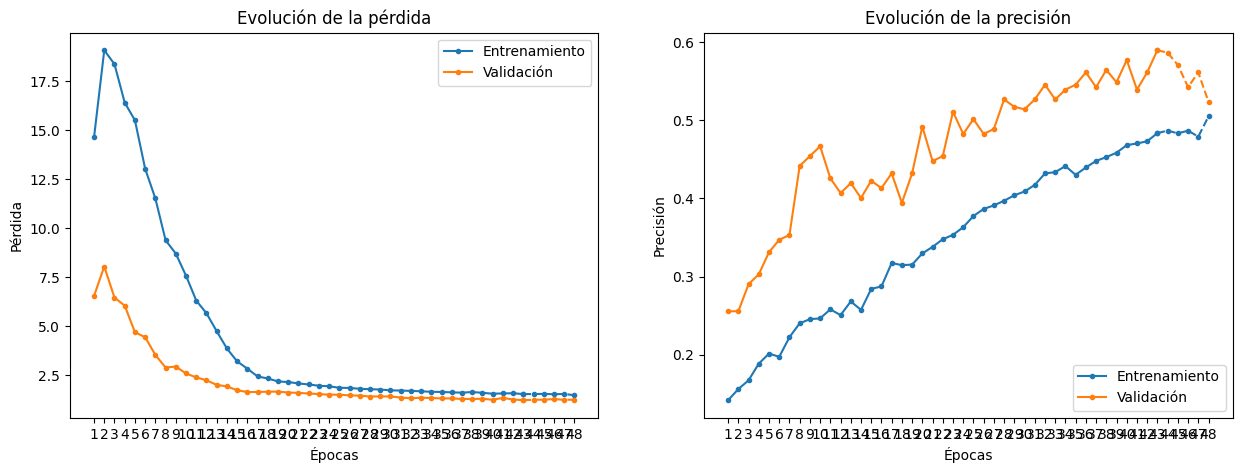

In [59]:
plot_history(history_mn_aug, early_stop = early_stopping_aug)

ELos resultados obtenidos son muy similares al caso anterior. Es decir, la aplicación de *"Data Augmentation"* en este caso no nos ha aportado demasiado. Los resultados por lo tanto no son sastisfactorios, y debemos seguir investigando otros modelos y técnicas.

In [60]:
y_pred = make_prediction(model_mn_aug, test_set)

13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 475ms/step



Informe de clasificación
                        precision    recall  f1-score   support

        Alfred_Sisley       0.00      0.00      0.00        52
          Edgar_Degas       0.75      0.61      0.68       140
       Francisco_Goya       0.38      0.09      0.14        58
         Marc_Chagall       0.88      0.48      0.62        48
        Pablo_Picasso       0.50      0.59      0.54        88
         Paul_Gauguin       0.33      0.02      0.03        62
Pierre-Auguste_Renoir       0.68      0.72      0.70        67
            Rembrandt       0.45      0.90      0.60        52
               Titian       0.87      0.51      0.64        51
     Vincent_van_Gogh       0.45      0.85      0.59       175

             accuracy                           0.55       793
            macro avg       0.53      0.48      0.45       793
         weighted avg       0.54      0.55      0.50       793



/Users/adriandelpozo/Desktop/MSc_BIG_DATA/ANÁLISIS_DE_DATOS_NO_ESTRUCTURADOS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adriandelpozo/Desktop/MSc_BIG_DATA/ANÁLISIS_DE_DATOS_NO_ESTRUCTURADOS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adriandelpozo/Desktop/MSc_BIG_DATA/ANÁLISIS_DE_DATOS_NO_ESTRUCTURADOS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 

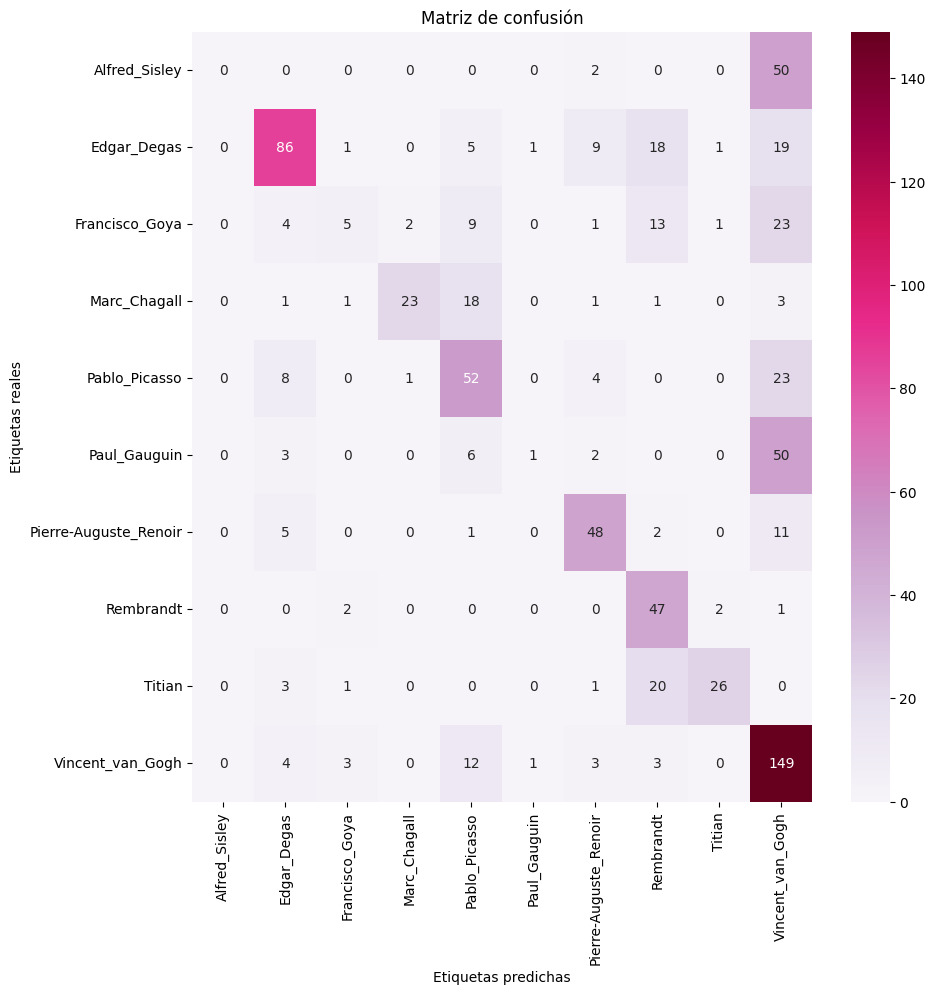

In [61]:
evaluate_prediction(model_mn_aug, y_test, y_pred, labels, plot_size=(10,10)) 

Tal como se anticipaba, este modelo no mejora al anterior. Sigue clasificando muchos cuadros dentro de la clase 'Vincent Van Gogh'. A pesar de haber probado distintas combinaciones de capas de *Data Augmentation* y sus respectivos parámetros, este ha sido el mejor resultado que se ha logrado obtener.

In [63]:
model_mn_aug.save('Model' + 'mn_aug.h5')

---
### 4.2.5. <b> VGG-16 </b>
El segundo modelo que se ha probado es **VGG-16**, una red neuronal convolucional desarrollada para el reto *ImageNet Large Scale Visual Recognition Challenge*. A diferencia de MobileNetV2, este modelo es más pesado y cuenta con un mayor número de parámetros. Tras eliminar sus capas densas finales, se le añadieron capas adicionales más específicas para adaptarlo mejor a la tarea actual.


In [65]:
base_model_vgg = VGG16(weights = 'imagenet')

base_model_vgg = Model(inputs = base_model_vgg.input, 
                      outputs = base_model_vgg.get_layer('flatten').output)

In [66]:
def vgg_tuning(base_model, lr, augmentation = False):
    """
    Esta función permite realizar el ajuste fino (fine-tuning) de la red VGG-16 
    añadiendo capas adicionales específicas para la tarea de clasificación.

    :param base_model: modelo base preentrenado (VGG-16 sin las capas superiores)
    :param float lr: valor del learning rate del optimizador
    :param bool augmentation: True si se desea aplicar técnicas de Data Augmentation
    """
    # Limpia la sesión actual de Keras para evitar residuos de modelos anteriores
    keras.backend.clear_session()

    # Congela los pesos del modelo base para no modificarlos durante el entrenamiento
    for layer in base_model.layers:
        layer.trainable = False
    
    # Capa de entrada
    inputs = keras.Input(shape=(224, 224, 3))
    x = inputs

    # Aplicación de Data Augmentation si está activado
    if augmentation == True:
        x = keras.layers.RandomRotation(0.4, fill_mode='nearest')(x)
        x = keras.layers.RandomFlip('horizontal')(x)
        x = keras.layers.RandomFlip('vertical')(x)
        x = keras.layers.RandomContrast(0.1)(x)

    # Preprocesado de las imágenes y paso al modelo base
    x = keras.applications.vgg16.preprocess_input(x)
    x = base_model(x)

    # Capas densas añadidas para especializar el modelo a la nueva tarea
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dropout(0.1)(x)
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(64, activation='relu')(x)
    x = keras.layers.Dropout(0.3)(x)

    # Capa de salida con activación softmax para clasificación multiclase
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

    # Construcción final del modelo
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compilación del modelo con función de pérdida adecuada y métrica de precisión
    model.compile(optimizer=Adam(lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [68]:
model_vgg = vgg_tuning(base_model_vgg, lr = 0.001)
model_vgg.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 25088)     │ 14,714,688 │ add[0][0]         │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │ 12,845,568 │ functional_1[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     16,448 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 10)        │        650 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 27,708,682 (105.70 MB)

 Trainable params: 12,993,994 (49.57 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [69]:
history_vgg, early_stopping_vgg = train_model(model_vgg, bs = 64, eps = 50, early_stopping = True, pat = 5)

Epoch 1/50
36/45 ━━━━━━━━━━━━━━━━━━━━ 6s 721ms/step - accuracy: 0.2015 - loss: 319.4612

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 804ms/step - accuracy: 0.2113 - loss: 348.2424 - val_accuracy: 0.5300 - val_loss: 185.3091
Epoch 2/50
37/45 ━━━━━━━━━━━━━━━━━━━━ 5s 704ms/step - accuracy: 0.3994 - loss: 513.7251

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 773ms/step - accuracy: 0.4003 - loss: 512.0697 - val_accuracy: 0.6215 - val_loss: 197.2008
Epoch 3/50
29/45 ━━━━━━━━━━━━━━━━━━━━ 11s 706ms/step - accuracy: 0.5613 - loss: 338.2287

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 775ms/step - accuracy: 0.5588 - loss: 355.6686 - val_accuracy: 0.6435 - val_loss: 236.3289
Epoch 4/50
31/45 ━━━━━━━━━━━━━━━━━━━━ 9s 712ms/step - accuracy: 0.6436 - loss: 320.5922 

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 779ms/step - accuracy: 0.6464 - loss: 327.9304 - val_accuracy: 0.7098 - val_loss: 227.8693
Epoch 5/50
32/45 ━━━━━━━━━━━━━━━━━━━━ 9s 705ms/step - accuracy: 0.7263 - loss: 262.1963

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 775ms/step - accuracy: 0.7310 - loss: 257.8396 - val_accuracy: 0.7350 - val_loss: 243.7569
Epoch 6/50
31/45 ━━━━━━━━━━━━━━━━━━━━ 9s 702ms/step - accuracy: 0.8159 - loss: 155.4521 

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 769ms/step - accuracy: 0.8156 - loss: 153.6789 - val_accuracy: 0.7382 - val_loss: 271.2629
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


In [70]:
model_vgg.save('vgg_finetuned_trained.h5')

Resumen del entrenamiento:

Número total de épocas: 6
Época con mejor resultado (weights restaurados): 1
Accuracy en entrenamiento (época 1): 0.2523593008518219
Accuracy en validación (época 1): 0.5299684405326843
Loss en entrenamiento (época 1): 458.05999755859375
Loss en validación (época 1): 185.30906677246094





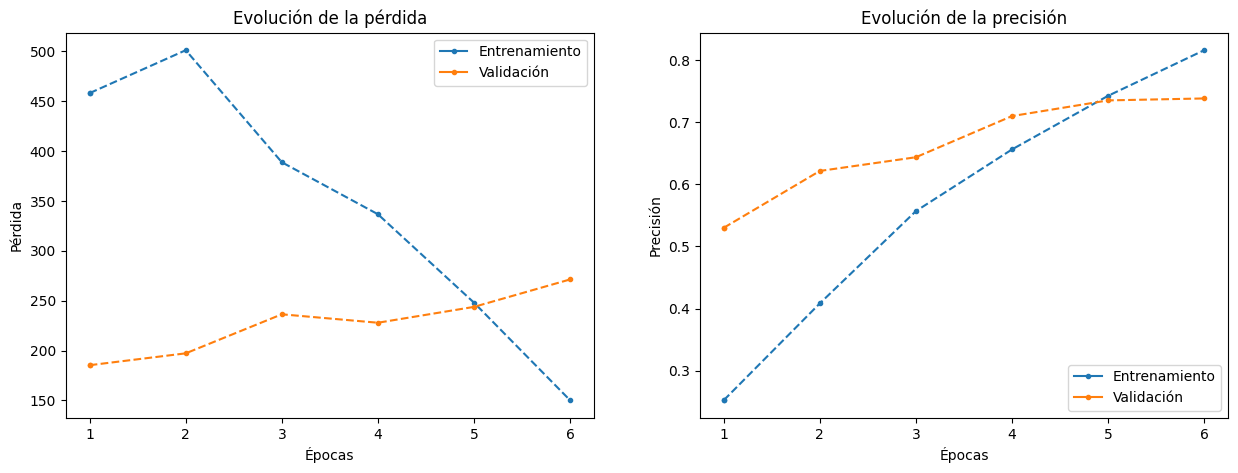

In [71]:
plot_history(history_vgg,early_stop = early_stopping_vgg)

En las épocas finales se observa cierta tendencia al sobreajuste, tanto en la gráfica que nos muestra la evolución de la pérdida como en la gráfica de la evolución de la precisión.  En la época 6, tenemos una precisión cercana al 80% en entrenamiento y en torno al 74% en validación. (Hay que tener en cuenta que lo que se muestra como mejor modelo en la parte superior de las gráficas se hace tomando como criterio el loss en validación).

In [72]:
y_pred_vgg = make_prediction(model_vgg, test_set)

13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 683ms/step



Informe de clasificación
                        precision    recall  f1-score   support

        Alfred_Sisley       0.00      0.00      0.00        52
          Edgar_Degas       0.85      0.52      0.65       140
       Francisco_Goya       0.69      0.43      0.53        58
         Marc_Chagall       0.60      0.52      0.56        48
        Pablo_Picasso       0.44      0.61      0.51        88
         Paul_Gauguin       0.00      0.00      0.00        62
Pierre-Auguste_Renoir       0.82      0.48      0.60        67
            Rembrandt       1.00      0.04      0.07        52
               Titian       0.31      0.94      0.47        51
     Vincent_van_Gogh       0.50      0.88      0.63       175

             accuracy                           0.52       793
            macro avg       0.52      0.44      0.40       793
         weighted avg       0.55      0.52      0.47       793



/Users/adriandelpozo/Desktop/MSc_BIG_DATA/ANÁLISIS_DE_DATOS_NO_ESTRUCTURADOS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adriandelpozo/Desktop/MSc_BIG_DATA/ANÁLISIS_DE_DATOS_NO_ESTRUCTURADOS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adriandelpozo/Desktop/MSc_BIG_DATA/ANÁLISIS_DE_DATOS_NO_ESTRUCTURADOS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 

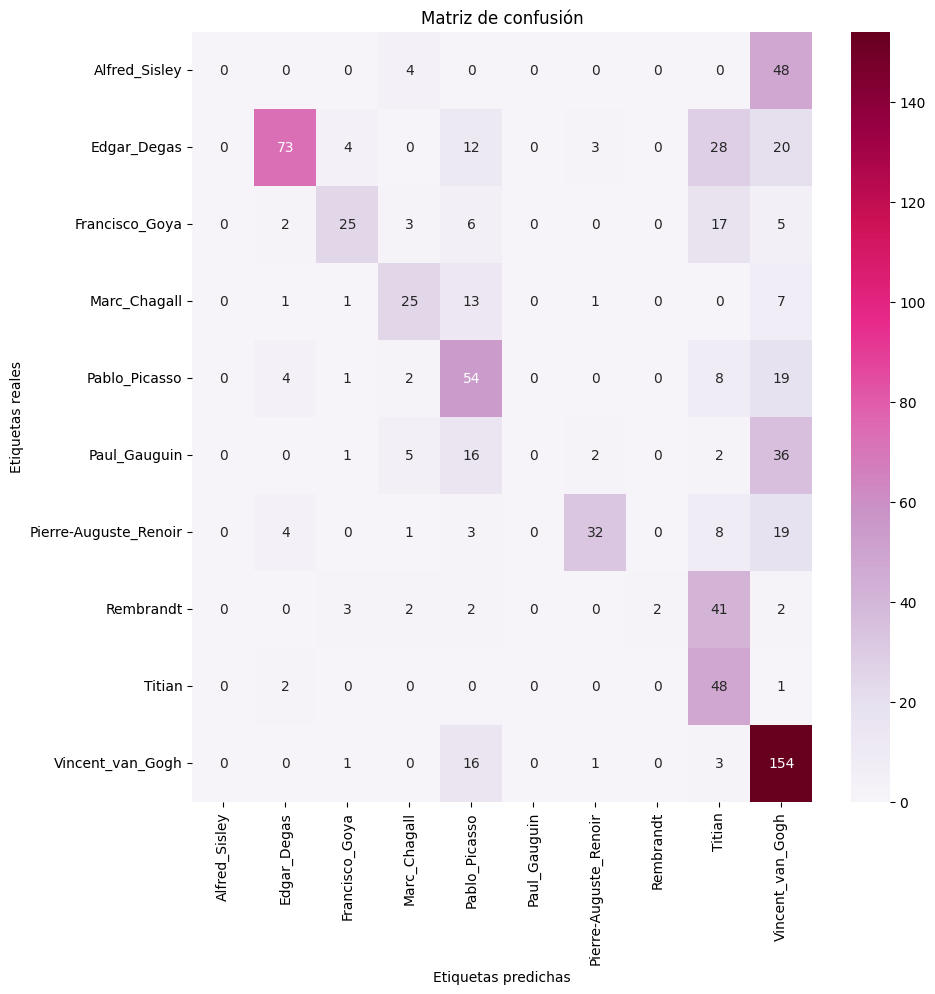

In [73]:
evaluate_prediction(model_vgg, y_test, y_pred_vgg, labels, plot_size=(10,10)) 

Vemos resultados muy pobres. Por ejemplo, los cuadros de ninguno de los cuadros de Paul Gaugin son reconocidos como suyos, distribuyendose la mayor parte de ellos entre Pablo Picasso y Vicent Van Gogh. Por lo tanto, deberemos seguir explorando nuevas posibilidades. A continuación, vamos a recurrir a la técnica de *Data Augmentation*, también con la idea de solucionar el sobreajuste que veíamos a partir de la época 5 de entrenamiento. 

---
### 4.2.6. VGG16 con Data Augmentation
Dado que los modelos anteriores mostraban signos evidentes de sobreajuste (*overfitting*), consideramos que aplicar técnicas de *data augmentation* podría ayudar a mejorar la generalización.  

In [74]:
model_vgg_aug = vgg_tuning(base_model_vgg, lr = 0.01, augmentation = True)
model_vgg_aug.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation     │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (RandomRotation)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 224, 224,  │          0 │ random_rotation[… │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip_1       │ (None, 224, 224,  │          0 │ random_flip[0][0] │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_contrast     │ (None, 224, 224,  │          0 │ random_flip_1[0]… │
│ (RandomContrast)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ random_contrast[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ random_contrast[… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ random_contrast[… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 25088)     │ 14,714,688 │ add[0][0]         │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │ 12,845,568 │ functional_1[2][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     16,448 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 10)        │        650 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 27,708,682 (105.70 MB)

 Trainable params: 12,993,994 (49.57 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [75]:
# Entrenamiento
history_vgg_aug, early_stopping_vgg_aug = train_model(model_vgg_aug,
                                                      bs = 64,
                                                      eps = 50,
                                                      early_stopping = True, 
                                                      pat = 5)

Epoch 1/50
28/45 ━━━━━━━━━━━━━━━━━━━━ 13s 806ms/step - accuracy: 0.1380 - loss: 19233.6504

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 903ms/step - accuracy: 0.1486 - loss: 29014.8262 - val_accuracy: 0.2555 - val_loss: 39947.2539
Epoch 2/50
30/45 ━━━━━━━━━━━━━━━━━━━━ 11s 770ms/step - accuracy: 0.1780 - loss: 127185.9219

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 38s 839ms/step - accuracy: 0.1851 - loss: 122922.2188 - val_accuracy: 0.3785 - val_loss: 37960.5742
Epoch 3/50
28/45 ━━━━━━━━━━━━━━━━━━━━ 13s 765ms/step - accuracy: 0.2031 - loss: 109996.5781

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 38s 836ms/step - accuracy: 0.2119 - loss: 105722.5859 - val_accuracy: 0.2429 - val_loss: 47105.4180
Epoch 4/50
35/45 ━━━━━━━━━━━━━━━━━━━━ 7s 780ms/step - accuracy: 0.2392 - loss: 95031.1094

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 38s 843ms/step - accuracy: 0.2414 - loss: 93236.5625 - val_accuracy: 0.3596 - val_loss: 39118.7227
Epoch 5/50
28/45 ━━━━━━━━━━━━━━━━━━━━ 13s 766ms/step - accuracy: 0.2209 - loss: 74535.8594

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 38s 833ms/step - accuracy: 0.2252 - loss: 71754.1953 - val_accuracy: 0.3502 - val_loss: 17282.5273
Epoch 6/50
28/45 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/step - accuracy: 0.2521 - loss: 37231.8633

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 37s 825ms/step - accuracy: 0.2476 - loss: 38895.4648 - val_accuracy: 0.3028 - val_loss: 23209.3594
Epoch 7/50
31/45 ━━━━━━━━━━━━━━━━━━━━ 10s 759ms/step - accuracy: 0.2391 - loss: 45968.0508

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 37s 826ms/step - accuracy: 0.2387 - loss: 47406.9727 - val_accuracy: 0.3281 - val_loss: 20610.3652
Epoch 8/50
37/45 ━━━━━━━━━━━━━━━━━━━━ 6s 755ms/step - accuracy: 0.2628 - loss: 45204.9961

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 37s 822ms/step - accuracy: 0.2639 - loss: 46039.4727 - val_accuracy: 0.3628 - val_loss: 36421.4609
Epoch 9/50
36/45 ━━━━━━━━━━━━━━━━━━━━ 6s 758ms/step - accuracy: 0.2709 - loss: 43912.7852

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 37s 824ms/step - accuracy: 0.2705 - loss: 43648.1133 - val_accuracy: 0.2650 - val_loss: 41467.9414
Epoch 10/50
27/45 ━━━━━━━━━━━━━━━━━━━━ 13s 764ms/step - accuracy: 0.2850 - loss: 60747.3242

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 38s 831ms/step - accuracy: 0.2839 - loss: 64355.0977 - val_accuracy: 0.3249 - val_loss: 32878.6133
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.


Resumen del entrenamiento:

Número total de épocas: 10
Época con mejor resultado (weights restaurados): 5
Accuracy en entrenamiento (época 5): 0.23313526809215546
Accuracy en validación (época 5): 0.3501577377319336
Loss en entrenamiento (época 5): 62806.0234375
Loss en validación (época 5): 17282.52734375





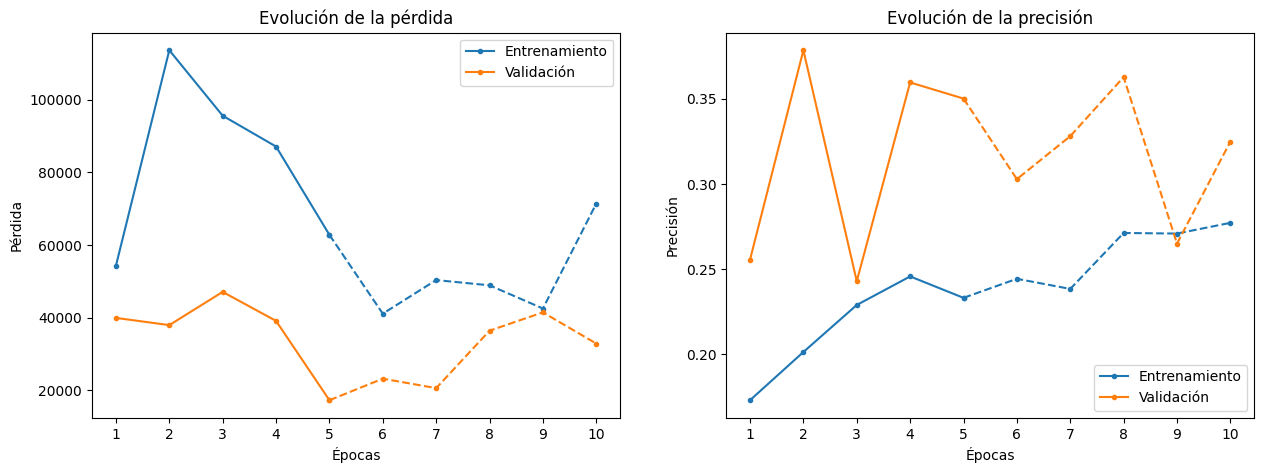

In [76]:
plot_history(history_vgg_aug, early_stop = early_stopping_vgg_aug)

A pesar de haber aplicado técnicas de *data augmentation*, el modelo no muestra señales de mejora.  
Durante el entrenamiento surgió un problema de **infraajuste** (*underfitting*), algo que no se había observado en las configuraciones anteriores, al menos de forma tan evidente.  
Además, la evolución de la *accuracy* no fue progresiva ni estable, sino que presentó múltiples oscilaciones abruptas, probablemente causadas por un valor de *learning rate* demasiado elevado.

In [77]:
y_pred_vgg_aug = make_prediction(model_vgg_aug, test_set)

13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 679ms/step


/Users/adriandelpozo/Desktop/MSc_BIG_DATA/ANÁLISIS_DE_DATOS_NO_ESTRUCTURADOS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adriandelpozo/Desktop/MSc_BIG_DATA/ANÁLISIS_DE_DATOS_NO_ESTRUCTURADOS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adriandelpozo/Desktop/MSc_BIG_DATA/ANÁLISIS_DE_DATOS_NO_ESTRUCTURADOS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 


Informe de clasificación
                        precision    recall  f1-score   support

        Alfred_Sisley       0.00      0.00      0.00        52
          Edgar_Degas       0.36      0.59      0.45       140
       Francisco_Goya       0.27      0.07      0.11        58
         Marc_Chagall       0.00      0.00      0.00        48
        Pablo_Picasso       0.35      0.52      0.42        88
         Paul_Gauguin       0.00      0.00      0.00        62
Pierre-Auguste_Renoir       0.00      0.00      0.00        67
            Rembrandt       0.00      0.00      0.00        52
               Titian       0.55      0.22      0.31        51
     Vincent_van_Gogh       0.42      0.96      0.59       175

             accuracy                           0.39       793
            macro avg       0.19      0.24      0.19       793
         weighted avg       0.25      0.39      0.28       793



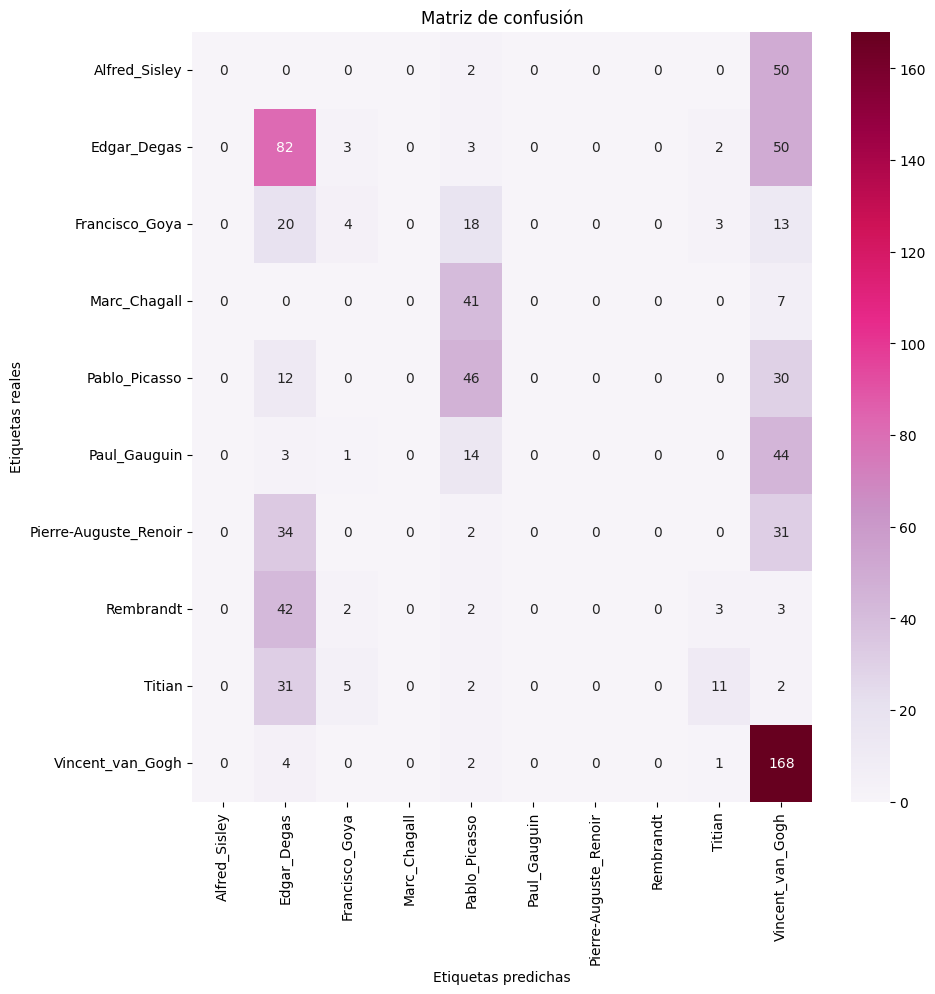

In [78]:
evaluate_prediction(model_vgg_aug, y_test, y_pred_vgg_aug, labels, plot_size=(10,10)) 

Los resultados obtenidos están entre los peores alcanzados: la *accuracy* cayó considerablemente, situándose en apenas **0.21**.  
Además, la gran mayoría de las predicciones fueron clasificadas erróneamente como pertenecientes a la clase **'Vincent Van Gogh'**, lo que evidencia un fuerte sesgo del modelo. Para otros pintores, tales como Renoir o Rembrandt, ninguno de sus cuadros fue clasificado por el modelo como suyo. Debemos, por tanto, continuar investigando.

In [79]:
model_vgg_aug.save('vgg_aug.h5')

---
### 4.2.7. <b> ResNet-50 </b>
El último modelo probado ha sido **ResNet50**, el cual es también el que contiene un mayor número de parámetros.  
Tras eliminar su última capa densa, se le añadieron capas adicionales específicas para la tarea de clasificación que estamos abordando.

In [81]:
base_model_rn50 = ResNet50(weights='imagenet')

base_model_rn50 = Model(inputs=base_model_rn50.input, 
                    outputs=base_model_rn50.get_layer('avg_pool').output)

In [82]:
base_model_rn50.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [85]:
def resnet_tuning(base_model, lr, augmentation=False): 
    """
    Función para realizar el fine-tuning y personalización del modelo ResNet-50.
    
    :param base_model: modelo base preentrenado
    :param float lr: valor del learning rate para el optimizador
    :param bool augmentation: indica si se desea aplicar Data Augmentation
    """
    # Reinicia la sesión de Keras para evitar conflictos con modelos anteriores
    keras.backend.clear_session()
    
    # Congela los pesos de las capas del modelo ResNet50
    for layer in base_model.layers:
        layer.trainable = False

    # Capa de entrada
    inputs = keras.Input(shape=(224, 224, 3))
    x = inputs

    # Aplicación de técnicas de Data Augmentation si está activado
    if augmentation:
        x = keras.layers.RandomFlip('horizontal')(x) 
        x = keras.layers.RandomFlip('vertical')(x)
        x = keras.layers.RandomRotation(0.4, fill_mode='nearest')(x)
        x = keras.layers.RandomContrast(0.1)(x)
        x = keras.layers.RandomZoom(0.5)(x)

    # Preprocesamiento específico de ResNet50
    x = keras.applications.resnet50.preprocess_input(x)
    x = base_model(x)

    # Capas personalizadas para adaptar el modelo a la tarea concreta
    x = keras.layers.Dense(512, activation='relu')(x) 
    x = keras.layers.Dropout(0.3)(x) 
    x = keras.layers.Dense(256, activation='relu')(x) 
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(64, activation='relu')(x) 
    x = keras.layers.Dropout(0.1)(x)
    x = keras.layers.Dense(num_classes, activation='softmax')(x)

    # Definición del modelo completo
    outputs = x
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compilación del modelo con función de pérdida y métrica
    model.compile(optimizer=Adam(lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [86]:
model_rn = resnet_tuning(base_model_rn50, lr = 0.001)
model_rn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 2048)      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  1,049,088 │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     16,448 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 10)        │        650 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,785,226 (94.55 MB)

 Trainable params: 1,197,514 (4.57 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [87]:
# Entrenamiento
history_rn, early_stop_rn = train_model(model_rn, bs = 64, eps = 50, early_stopping = True, pat = 3)

Epoch 1/50
31/45 ━━━━━━━━━━━━━━━━━━━━ 7s 542ms/step - accuracy: 0.1996 - loss: 10.8622

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 747ms/step - accuracy: 0.2096 - loss: 12.1628 - val_accuracy: 0.4479 - val_loss: 5.1272
Epoch 2/50
34/45 ━━━━━━━━━━━━━━━━━━━━ 5s 493ms/step - accuracy: 0.2780 - loss: 19.4562

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 548ms/step - accuracy: 0.2818 - loss: 19.3322 - val_accuracy: 0.5047 - val_loss: 5.4499
Epoch 3/50
33/45 ━━━━━━━━━━━━━━━━━━━━ 5s 490ms/step - accuracy: 0.3272 - loss: 18.4686

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 548ms/step - accuracy: 0.3357 - loss: 18.1529 - val_accuracy: 0.5268 - val_loss: 7.6182
Epoch 4/50
27/45 ━━━━━━━━━━━━━━━━━━━━ 8s 484ms/step - accuracy: 0.4278 - loss: 17.0595

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 542ms/step - accuracy: 0.4349 - loss: 16.8881 - val_accuracy: 0.6183 - val_loss: 6.9088
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


Resumen del entrenamiento:

Número total de épocas: 4
Época con mejor resultado (weights restaurados): 1
Accuracy en entrenamiento (época 1): 0.23663054406642914
Accuracy en validación (época 1): 0.44794952869415283
Loss en entrenamiento (época 1): 15.445923805236816
Loss en validación (época 1): 5.127222537994385





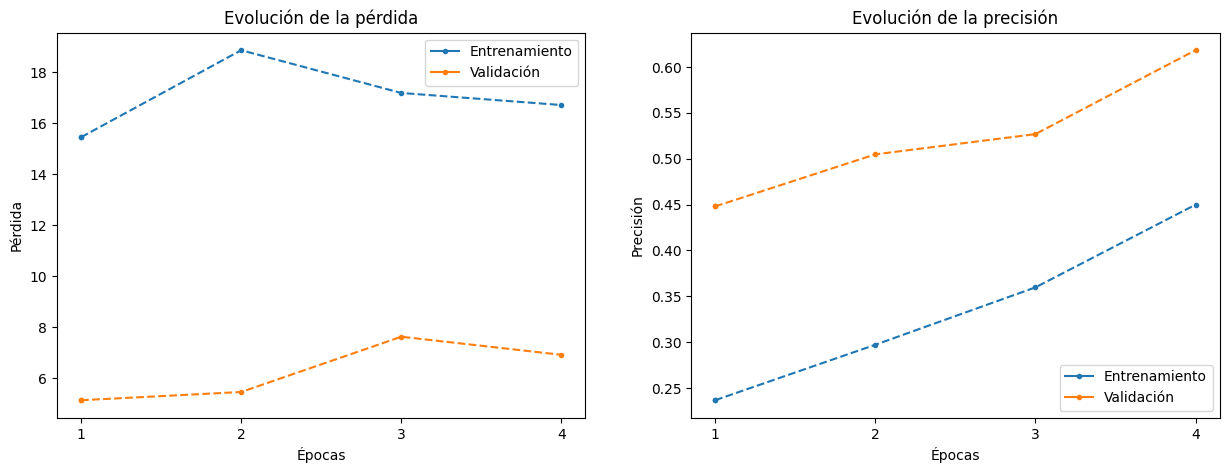

In [88]:
plot_history(history_rn, early_stop = early_stop_rn)

En este caso observamos tambien un comportamiento de *underfitting*, con la gráfica de la evolucion de la función de pérdida del conjunto de validación por debajo de la de entrenamiento. Sin embargo, seguimos sin obtener resultados demasiado buenos, como se puede deducir de la precisión. Vamos a continuación a analizar la matriz de confusión, que arrojará más luz sobre este hecho. 

In [89]:
y_pred_rn = make_prediction(model_rn, test_set)

13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 814ms/step


/Users/adriandelpozo/Desktop/MSc_BIG_DATA/ANÁLISIS_DE_DATOS_NO_ESTRUCTURADOS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adriandelpozo/Desktop/MSc_BIG_DATA/ANÁLISIS_DE_DATOS_NO_ESTRUCTURADOS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adriandelpozo/Desktop/MSc_BIG_DATA/ANÁLISIS_DE_DATOS_NO_ESTRUCTURADOS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 


Informe de clasificación
                        precision    recall  f1-score   support

        Alfred_Sisley       0.00      0.00      0.00        52
          Edgar_Degas       0.63      0.24      0.34       140
       Francisco_Goya       0.00      0.00      0.00        58
         Marc_Chagall       1.00      0.10      0.19        48
        Pablo_Picasso       0.73      0.45      0.56        88
         Paul_Gauguin       0.78      0.23      0.35        62
Pierre-Auguste_Renoir       0.86      0.09      0.16        67
            Rembrandt       0.28      0.98      0.44        52
               Titian       0.37      0.51      0.43        51
     Vincent_van_Gogh       0.40      0.92      0.56       175

             accuracy                           0.42       793
            macro avg       0.50      0.35      0.30       793
         weighted avg       0.52      0.42      0.35       793



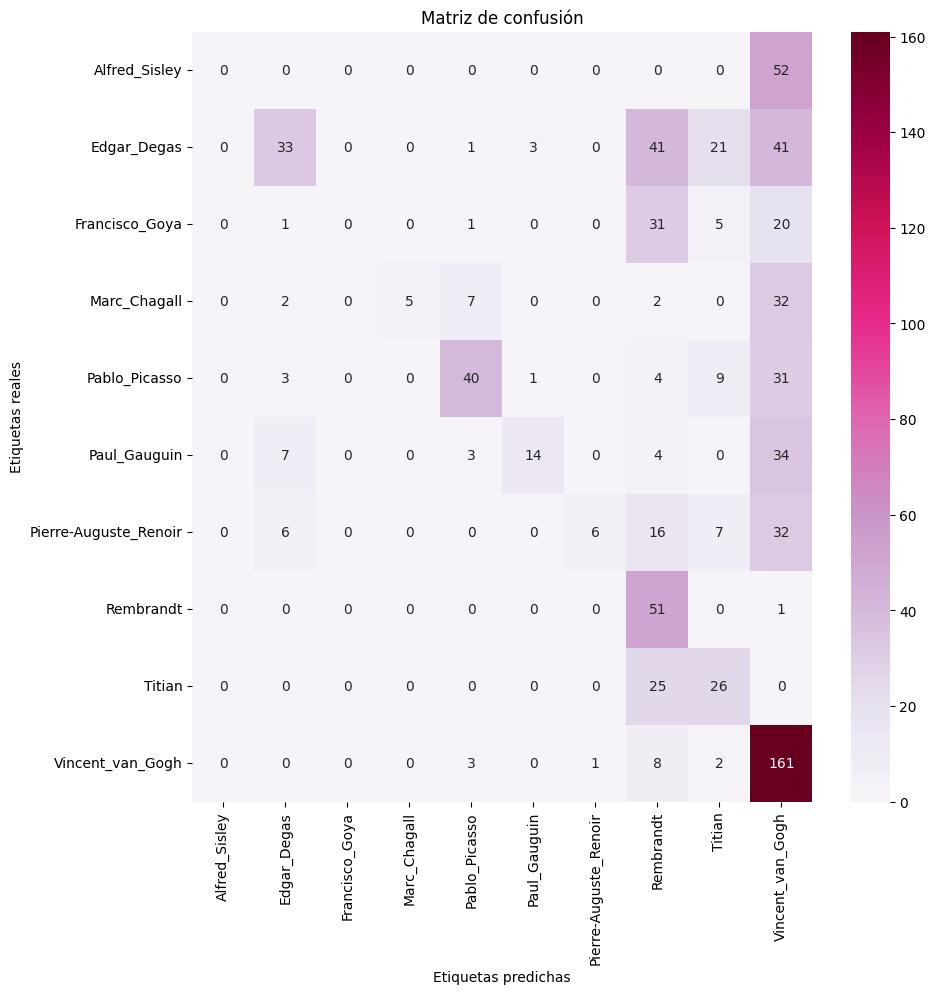

In [90]:
evaluate_prediction(model_rn, y_test, y_pred_rn, labels, plot_size=(10,10)) 

Los resultados obtenidos son comparables a los de MobileNetV2. Al igual que en ese caso, el número de errores es elevado y la mayoría de las predicciones incorrectas acaban asignándose a la clase ‘Vincent Van Gogh’. Sin embargo, es curioso observar que este modelo sí clasifica bien los cuadros de Rembrandt, mientras que la red VGG16 no asignaba ni un solo cuadro a su pintor original.

In [91]:
model_rn.save('rn.h5')

---
### 4.2.8 ResNet con Data Augmentation
Los capas empleadas en esta configuración son, una vez más, las mismas que se describieron anteriormente en la sección dedicada a MobileNetV2.

In [92]:
model_rn_aug = resnet_tuning(base_model_rn50, lr = 0.001, augmentation = True)
model_rn_aug.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip_1       │ (None, 224, 224,  │          0 │ random_flip[0][0] │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation     │ (None, 224, 224,  │          0 │ random_flip_1[0]… │
│ (RandomRotation)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_contrast     │ (None, 224, 224,  │          0 │ random_rotation[… │
│ (RandomContrast)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom         │ (None, 224, 224,  │          0 │ random_contrast[… │
│ (RandomZoom)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ random_zoom[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ random_zoom[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ random_zoom[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 2048)      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  1,049,088 │ functional_1[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     16,448 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 10)        │        650 │ dropout_2[0][0] 

 Total params: 24,785,226 (94.55 MB)

 Trainable params: 1,197,514 (4.57 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [93]:
# Entrenamiento
history_rn_aug, early_stop_aug = train_model(model_rn_aug, bs = 64, eps = 50, 
                                            early_stopping = True, pat = 3)

Epoch 1/50
29/45 ━━━━━━━━━━━━━━━━━━━━ 9s 608ms/step - accuracy: 0.1263 - loss: 13.0264 

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 776ms/step - accuracy: 0.1391 - loss: 14.7713 - val_accuracy: 0.3596 - val_loss: 5.5972
Epoch 2/50
28/45 ━━━━━━━━━━━━━━━━━━━━ 9s 584ms/step - accuracy: 0.1900 - loss: 24.5648 

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 635ms/step - accuracy: 0.1951 - loss: 24.5524 - val_accuracy: 0.4038 - val_loss: 5.7073
Epoch 3/50
34/45 ━━━━━━━━━━━━━━━━━━━━ 6s 576ms/step - accuracy: 0.2331 - loss: 24.4592

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 634ms/step - accuracy: 0.2351 - loss: 24.4874 - val_accuracy: 0.3817 - val_loss: 9.1380
Epoch 4/50
33/45 ━━━━━━━━━━━━━━━━━━━━ 7s 601ms/step - accuracy: 0.2412 - loss: 24.9558

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 649ms/step - accuracy: 0.2483 - loss: 24.4078 - val_accuracy: 0.4953 - val_loss: 6.8215
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


Resumen del entrenamiento:

Número total de épocas: 4
Época con mejor resultado (weights restaurados): 1
Accuracy en entrenamiento (época 1): 0.16917161643505096
Accuracy en validación (época 1): 0.35962146520614624
Loss en entrenamiento (época 1): 18.4046573638916
Loss en validación (época 1): 5.597208499908447





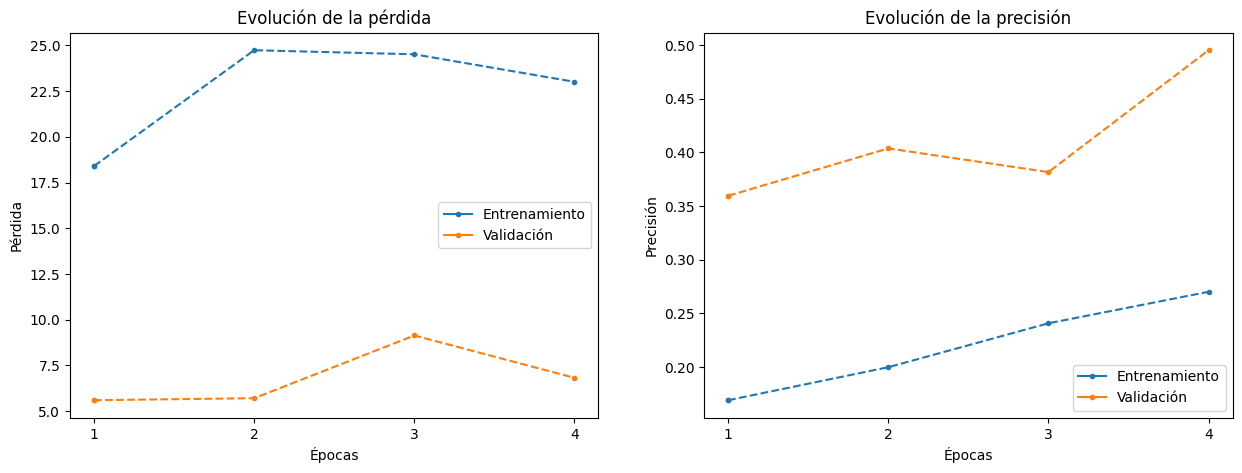

In [94]:
plot_history(history_rn_aug, early_stop = early_stop_aug)

Recurriendo a *Data Augmentation* no parece que hayamos solucionado el problema del *under-fitting*, tal y como se desprende de las gráficas superiores.

In [95]:
y_pred_rn_aug = make_prediction(model_rn_aug, test_set)

13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 863ms/step


/Users/adriandelpozo/Desktop/MSc_BIG_DATA/ANÁLISIS_DE_DATOS_NO_ESTRUCTURADOS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adriandelpozo/Desktop/MSc_BIG_DATA/ANÁLISIS_DE_DATOS_NO_ESTRUCTURADOS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adriandelpozo/Desktop/MSc_BIG_DATA/ANÁLISIS_DE_DATOS_NO_ESTRUCTURADOS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 


Informe de clasificación
                        precision    recall  f1-score   support

        Alfred_Sisley       0.00      0.00      0.00        52
          Edgar_Degas       0.00      0.00      0.00       140
       Francisco_Goya       0.35      0.14      0.20        58
         Marc_Chagall       0.73      0.33      0.46        48
        Pablo_Picasso       0.25      0.80      0.38        88
         Paul_Gauguin       0.65      0.27      0.39        62
Pierre-Auguste_Renoir       0.27      0.49      0.35        67
            Rembrandt       0.00      0.00      0.00        52
               Titian       0.25      0.08      0.12        51
     Vincent_van_Gogh       0.42      0.75      0.54       175

             accuracy                           0.35       793
            macro avg       0.29      0.29      0.24       793
         weighted avg       0.28      0.35      0.27       793



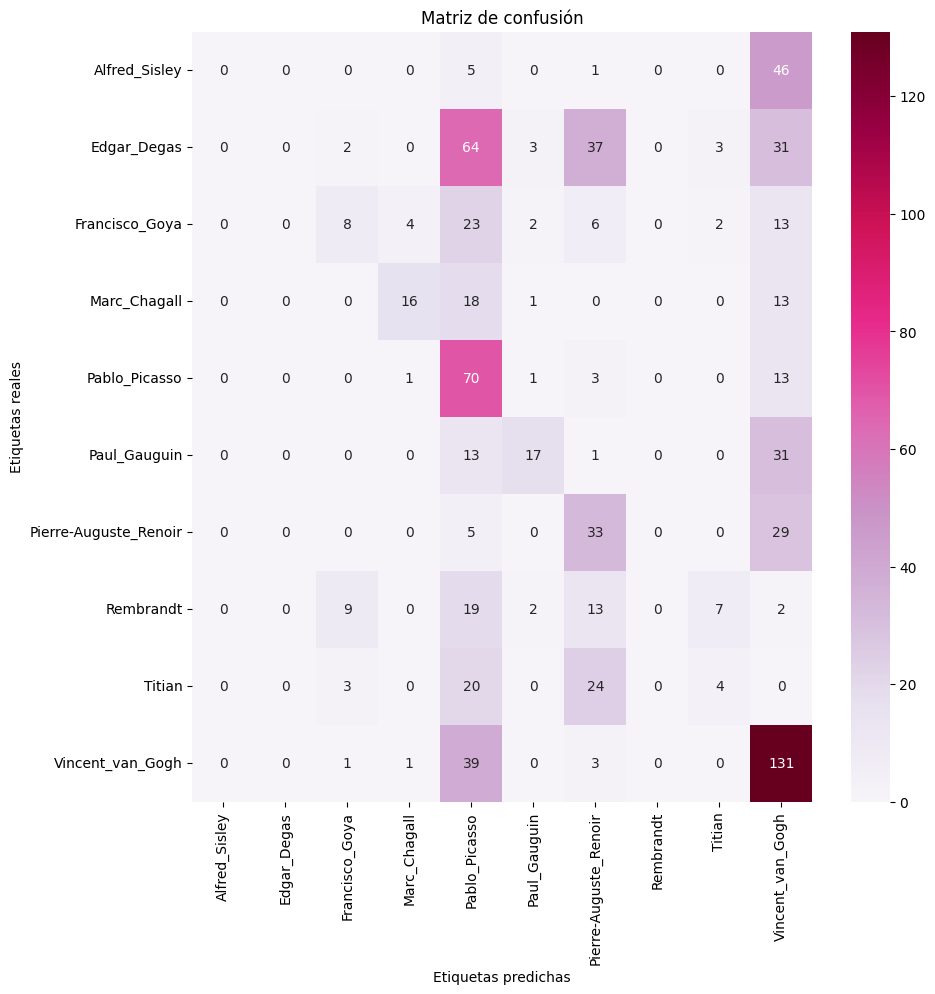

In [96]:
evaluate_prediction(model_rn_aug, y_test, y_pred_rn_aug, labels, plot_size=(10,10)) 

Aunque el modelo sigue cometiendo numerosos errores, sorprendentemente mejora en la clasificación de las obras de 'Renoir': en esta ocasión, consigue clasificarlas correctamente en 33 casos, frente a solo 6 aciertos obtenidos en el caso en que no se aplicó *Data Augmentation*.

In [98]:
model_rn_aug.save('Model' + 'rn_aug.h5')

---
## 4.3. Optimización de Hiperparámetros


Los hiperparámetros utilizados en los modelos anteriores fueron definidos manualmente. Con el objetivo de mejorar el rendimiento de las redes, hemos decidido adoptar un enfoque más sistemático para seleccionar los valores óptimos.  
En particular, aplicaremos esta optimización únicamente sobre el modelo VGG16, ya que ha sido el que mejores resultados ha mostrado hasta ahora y creemos que aún tiene margen de mejora.

La siguiente función define el modelo sobre el que se realizará la optimización. Su estructura es similar a la del modelo VGG-16 utilizado previamente, pero esta vez todos sus hiperparámetros pueden ajustarse dentro de un rango determinado o seleccionarse de una lista de valores candidatos.


In [37]:
def build_vgg(hp):
  # DEFINICIÓN DEL ESPACIO DE HIPERPARÁMETROS
  drop_rate = [0.0, 0.1, 0.2, 0.3]
  opt_functions = ['Adam', 'SGD', 'rmsprop']

  # Capa de entrada
  inputs = keras.Input(shape = (224,224,3))
  x = inputs

  # Aplicación de Data Augmentation condicional
  hp_flip = hp.Boolean('random_flip', default=False)
  if hp_flip:
    x = keras.layers.RandomFlip(mode='horizontal_and_vertical')(x)

  # Rotación aleatoria con factor ajustable
  hp_rotation = hp.Float('random_rotation', min_value=0.0, max_value=0.5, step=0.05)
  x = keras.layers.RandomRotation(factor=hp_rotation)(x)

  # Contraste aleatorio (si se indica un valor distinto de 0)
  hp_contrast = hp.Float('random_constrast', min_value=0.0, max_value=0.5, step=0.1)
  if hp_contrast != 0:
    x = keras.layers.RandomContrast(factor=hp_contrast)(x)

  # Preprocesamiento de las imágenes con la función de VGG16
  x = keras.applications.vgg16.preprocess_input(x)
  x = base_model_vgg(x)

  # Definición de la parte densa del modelo
  initializer = keras.initializers.GlorotUniform(seed=42)

  # Ajuste del número de neuronas para la primera capa densa
  hp_dense = hp.Int('dense_0', min_value=128, max_value=512, step=64)
  x = keras.layers.Dense(hp_dense, activation='relu', kernel_initializer=initializer)(x)

  # Dropout tras la primera capa densa
  hp_drop = hp.Choice('dropout_0', values=drop_rate)
  x = keras.layers.Dropout(hp_drop)(x)

  # Segunda capa densa y dropout asociado
  hp_dense1 = hp.Int('dense_1', min_value=64, max_value=256, step=32)
  x = keras.layers.Dense(hp_dense1, activation='relu', kernel_initializer=initializer)(x)
  hp_drop1 = hp.Choice('dropout_1', values=drop_rate)
  x = keras.layers.Dropout(hp_drop1)(x)

  # Tercera capa densa
  hp_dense2 = hp.Int('dense_2', min_value=32, max_value=128, step=16)
  x = keras.layers.Dense(hp_dense2, activation='relu', kernel_initializer=initializer)(x)

  # Capa de salida con activación softmax para clasificación multiclase
  x = keras.layers.Dense(num_classes, activation='softmax')(x)
  outputs = x

  model = keras.Model(inputs=inputs, outputs=outputs)

  # Selección del optimizador (Adam, SGD o RMSprop)
  hp_optimizer = hp.Choice('optimizer', values=opt_functions, default='Adam')
  opt = keras.optimizers.get(hp_optimizer)

  # Ajuste del learning rate con muestreo logarítmico
  opt.learning_rate = hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')

  # Compilación final del modelo
  model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  
  return model

Dado el elevado número de combinaciones posibles, se ha optado por utilizar la optimización bayesiana para ajustar el modelo.  
El objetivo principal del proceso de optimización es minimizar la función de pérdida (*loss*) sobre el conjunto de validación, como se especifica mediante el parámetro `objective`.

---
### 4.3.1. Optimización sobre la función de perdida

In [38]:
tuner = kt.BayesianOptimization(build_vgg,
                                objective = 'val_loss',
                                directory = './tuner',
                                max_trials = 25, overwrite = False,
                                project_name='vgg_tuning')

In [39]:
early_stop = EarlyStopping(monitor='val_loss', patience = 3, min_delta = 0.001, 
                           verbose=1, restore_best_weights = True) 
tuner.search(train_set, epochs = 25, validation_data = val_set,
             shuffle = True, callbacks = [early_stop])

Trial 25 Complete [00h 03m 42s]
val_loss: 196.5915985107422

Best val_loss So Far: 4.271747589111328
Total elapsed time: 01h 29m 48s


In [40]:
# Parámetros óptimos
best_param = tuner.get_best_hyperparameters()[0]

print('Best parameter VGG-16: ')
best_param.values

Best parameter VGG-16: 


{'random_flip': True,
 'random_rotation': 0.0,
 'random_constrast': 0.30000000000000004,
 'dense_0': 512,
 'dropout_0': 0.1,
 'dense_1': 96,
 'dropout_1': 0.2,
 'dense_2': 32,
 'optimizer': 'SGD',
 'lr': 0.0016046549825965487}

El modelo obtenido a través del proceso de optimización difiere del que habíamos definido manualmente.  
De hecho, ha demostrado un rendimiento significativamente superior al modelo con *Data Augmentation* que habíamos diseñado previamente.  
Por tanto, podemos considerar que los resultados alcanzados son satisfactorios.

In [41]:
vgg_tuned = tuner.hypermodel.build(best_param)
vgg_tuned.save('vgg_optimized_loss.h5')

Entrenamos el modelo VGG-16 con la mejor configuración de parámetros encontrada.

In [42]:
history, e_s = train_model(vgg_tuned, bs = 128, eps = 50, early_stopping = True, pat = 3)

Epoch 1/50
35/45 ━━━━━━━━━━━━━━━━━━━━ 7s 738ms/step - accuracy: 0.1943 - loss: 43.7778

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 811ms/step - accuracy: 0.2066 - loss: 43.0860 - val_accuracy: 0.3722 - val_loss: 22.6100
Epoch 2/50
28/45 ━━━━━━━━━━━━━━━━━━━━ 11s 695ms/step - accuracy: 0.3228 - loss: 29.1932

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 34s 761ms/step - accuracy: 0.3254 - loss: 28.9975 - val_accuracy: 0.5174 - val_loss: 10.6054
Epoch 3/50
37/45 ━━━━━━━━━━━━━━━━━━━━ 5s 705ms/step - accuracy: 0.4068 - loss: 21.3620

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 768ms/step - accuracy: 0.4052 - loss: 21.5336 - val_accuracy: 0.4700 - val_loss: 15.4980
Epoch 4/50
34/45 ━━━━━━━━━━━━━━━━━━━━ 7s 711ms/step - accuracy: 0.4506 - loss: 16.7166

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 774ms/step - accuracy: 0.4490 - loss: 16.7067 - val_accuracy: 0.5174 - val_loss: 9.9729
Epoch 5/50
30/45 ━━━━━━━━━━━━━━━━━━━━ 10s 715ms/step - accuracy: 0.4760 - loss: 14.3961

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 774ms/step - accuracy: 0.4758 - loss: 14.5015 - val_accuracy: 0.5394 - val_loss: 10.0481
Epoch 6/50
32/45 ━━━━━━━━━━━━━━━━━━━━ 9s 705ms/step - accuracy: 0.4798 - loss: 12.4962

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 767ms/step - accuracy: 0.4861 - loss: 12.1543 - val_accuracy: 0.5457 - val_loss: 9.5616
Epoch 7/50
27/45 ━━━━━━━━━━━━━━━━━━━━ 12s 700ms/step - accuracy: 0.5218 - loss: 9.9002

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 764ms/step - accuracy: 0.5271 - loss: 9.6974 - val_accuracy: 0.6120 - val_loss: 5.3941
Epoch 8/50
28/45 ━━━━━━━━━━━━━━━━━━━━ 11s 699ms/step - accuracy: 0.5768 - loss: 7.0779

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 765ms/step - accuracy: 0.5749 - loss: 7.3623 - val_accuracy: 0.5899 - val_loss: 7.9514
Epoch 9/50
37/45 ━━━━━━━━━━━━━━━━━━━━ 5s 698ms/step - accuracy: 0.5741 - loss: 7.3736

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 34s 761ms/step - accuracy: 0.5767 - loss: 7.2594 - val_accuracy: 0.6057 - val_loss: 4.6288
Epoch 10/50
29/45 ━━━━━━━━━━━━━━━━━━━━ 11s 701ms/step - accuracy: 0.6393 - loss: 5.3425

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 34s 763ms/step - accuracy: 0.6305 - loss: 5.5663 - val_accuracy: 0.5710 - val_loss: 7.6616
Epoch 11/50
36/45 ━━━━━━━━━━━━━━━━━━━━ 6s 699ms/step - accuracy: 0.5961 - loss: 5.3886

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 34s 763ms/step - accuracy: 0.5989 - loss: 5.3480 - val_accuracy: 0.5678 - val_loss: 4.0237
Epoch 12/50
32/45 ━━━━━━━━━━━━━━━━━━━━ 9s 703ms/step - accuracy: 0.6138 - loss: 4.6270

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 764ms/step - accuracy: 0.6199 - loss: 4.5502 - val_accuracy: 0.6593 - val_loss: 3.2072
Epoch 13/50
29/45 ━━━━━━━━━━━━━━━━━━━━ 11s 697ms/step - accuracy: 0.6368 - loss: 3.7345

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 34s 759ms/step - accuracy: 0.6353 - loss: 3.8402 - val_accuracy: 0.6057 - val_loss: 3.2465
Epoch 14/50
37/45 ━━━━━━━━━━━━━━━━━━━━ 5s 704ms/step - accuracy: 0.6600 - loss: 3.3538

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 765ms/step - accuracy: 0.6582 - loss: 3.3986 - val_accuracy: 0.6467 - val_loss: 4.4917
Epoch 15/50
29/45 ━━━━━━━━━━━━━━━━━━━━ 11s 696ms/step - accuracy: 0.6492 - loss: 3.6971

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 34s 758ms/step - accuracy: 0.6534 - loss: 3.5743 - val_accuracy: 0.6278 - val_loss: 3.0688
Epoch 16/50
30/45 ━━━━━━━━━━━━━━━━━━━━ 10s 702ms/step - accuracy: 0.7048 - loss: 2.5396

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 764ms/step - accuracy: 0.6994 - loss: 2.6264 - val_accuracy: 0.5552 - val_loss: 4.3283
Epoch 17/50
28/45 ━━━━━━━━━━━━━━━━━━━━ 11s 702ms/step - accuracy: 0.6714 - loss: 3.0283

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 34s 763ms/step - accuracy: 0.6763 - loss: 3.0064 - val_accuracy: 0.6025 - val_loss: 3.6137
Epoch 18/50
33/45 ━━━━━━━━━━━━━━━━━━━━ 8s 698ms/step - accuracy: 0.6561 - loss: 3.2103

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 34s 760ms/step - accuracy: 0.6648 - loss: 3.1140 - val_accuracy: 0.6025 - val_loss: 5.9420
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 15.


In [54]:
vgg_tuned.save('vgg_optimized_trained.h5')

Al observar los valores de `val_loss`, se puede ver que son incluso inferiores a los obtenidos durante el proceso de optimización, lo cual nos deja muy satisfechos con el resultado.

Resumen del entrenamiento:

Número total de épocas: 18
Época con mejor resultado (weights restaurados): 15
Accuracy en entrenamiento (época 15): 0.6613072156906128
Accuracy en validación (época 15): 0.6277602314949036
Loss en entrenamiento (época 15): 3.2994394302368164
Loss en validación (época 15): 3.0687777996063232





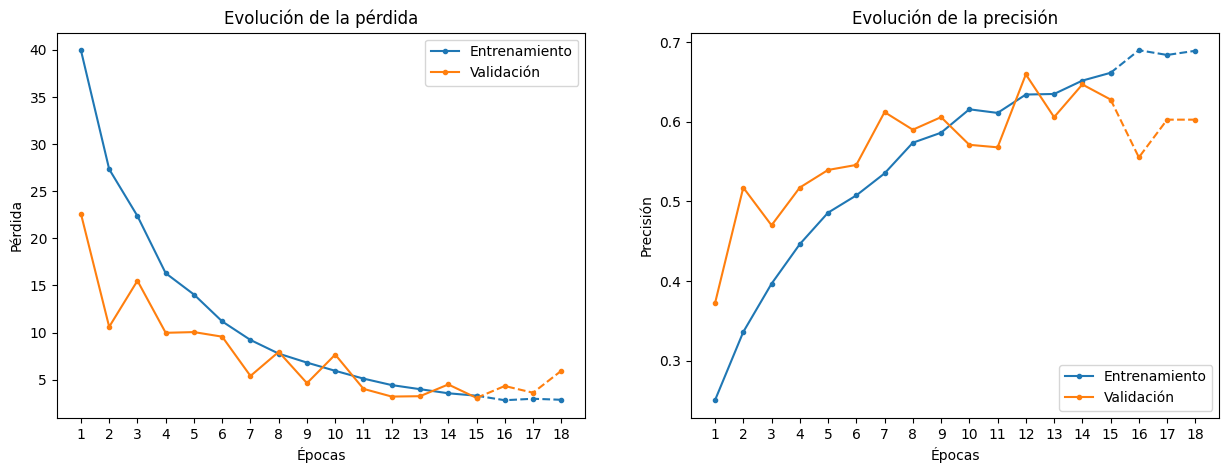

In [43]:
plot_history(history, early_stop = e_s)

El entrenamiento ha dado buenos resultados, ya que prácticamente no se observa sobreajuste: esto se puede comprobar en la gráfica de pérdida, donde las curvas de entrenamiento y validación están casi superpuestas. Solo en las épocas finales podríamos hablar de un ligero sobreajuste. El mismo comportamiento se observa en la gráfica de la evolución de la precisión. 

También cabe destacar que obtenemos cifras para *accuracy* y *loss* más esperanzadoras que en los casos anteriores, con valores superiores al 60 % tanto en entrenamiento como en validación para el *accuracy* e inferiores a 3.5 para la función de pérdida. 

In [44]:
y_pred = make_prediction(vgg_tuned, test_set)

13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 612ms/step



Informe de clasificación
                        precision    recall  f1-score   support

        Alfred_Sisley       0.57      0.23      0.33        52
          Edgar_Degas       0.53      0.85      0.65       140
       Francisco_Goya       0.53      0.71      0.61        58
         Marc_Chagall       0.87      0.71      0.78        48
        Pablo_Picasso       0.70      0.59      0.64        88
         Paul_Gauguin       0.65      0.35      0.46        62
Pierre-Auguste_Renoir       0.68      0.64      0.66        67
            Rembrandt       0.54      0.87      0.67        52
               Titian       0.87      0.25      0.39        51
     Vincent_van_Gogh       0.76      0.71      0.73       175

             accuracy                           0.64       793
            macro avg       0.67      0.59      0.59       793
         weighted avg       0.67      0.64      0.62       793



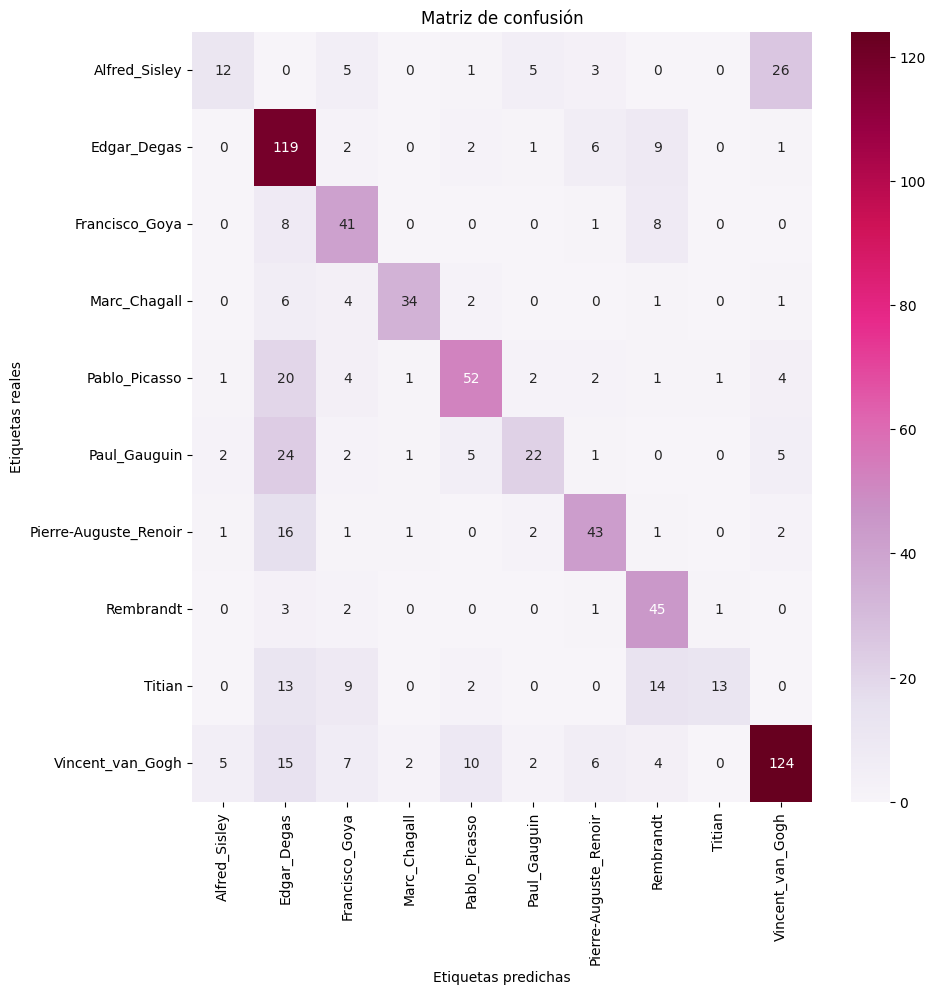

In [45]:
evaluate_prediction(vgg_tuned, y_test, y_pred, labels, plot_size=(10,10)) 

La precisión alcanzada es bastante buena, y al observar la matriz de confusión se puede ver que el número de errores ha disminuido notablemente. Se puede observar esto en la diagonal, que concentra los mayores valores (marcados en colores más intensos) .
Sin embargo, aún pensamos  que se puede mejorar la precisión, por lo que hemos decidido repetir el proceso de optimización, esta vez con el objetivo de **maximizar la accuracy** sobre el conjunto de validación.

---
### 4.3.2. Optimización sobre la precisión

In [46]:
tuner = kt.BayesianOptimization(build_vgg,
                                objective = 'val_accuracy',
                                directory = './tuner',
                                max_trials = 25, overwrite = False,
                                project_name='vgg_tuning')

Reloading Tuner from ./tuner/vgg_tuning/tuner0.json


In [47]:
early_stop = EarlyStopping(monitor='val_loss', patience = 3, min_delta = 0.001, 
                           verbose=1, restore_best_weights = True) 
tuner.search(train_set, epochs = 25, validation_data = val_set,
             shuffle = True, callbacks = [early_stop])

In [48]:
# Parametros óptimos
best_param = tuner.get_best_hyperparameters()[0]

print('Best parameter VGG-16: ')
best_param.values

Best parameter VGG-16: 


{'random_flip': False,
 'random_rotation': 0.1,
 'random_constrast': 0.30000000000000004,
 'dense_0': 128,
 'dropout_0': 0.1,
 'dense_1': 192,
 'dropout_1': 0.2,
 'dense_2': 112,
 'optimizer': 'Adam',
 'lr': 0.009102209798135995}

La configuración obtenida difiere de la anterior: entre las capas de *Data Augmentation* se ha mantenido `RandomFlip`, y también ha cambiado el número de neuronas en las capas densas. El optimizador utilizado sigue siendo el mismo, pero en esta ocasión el valor del *learning rate* ha disminuido.

In [49]:
vgg_tuned = tuner.hypermodel.build(best_param)
vgg_tuned.save('./Model/vgg_optimized_acc.h5')

A continuación, se lleva a cabo el entrenamiento y la evaluación del modelo optimizado.

In [50]:
history_acc, es_acc = train_model(vgg_tuned, bs = 128, eps = 50, early_stopping = True, pat = 3)

Epoch 1/50
36/45 ━━━━━━━━━━━━━━━━━━━━ 6s 767ms/step - accuracy: 0.1488 - loss: 3287.9990

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 846ms/step - accuracy: 0.1553 - loss: 3738.5483 - val_accuracy: 0.2650 - val_loss: 7438.7114
Epoch 2/50
32/45 ━━━━━━━━━━━━━━━━━━━━ 9s 704ms/step - accuracy: 0.2136 - loss: 7499.6768

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 781ms/step - accuracy: 0.2265 - loss: 7142.7891 - val_accuracy: 0.3060 - val_loss: 6467.8618
Epoch 3/50
28/45 ━━━━━━━━━━━━━━━━━━━━ 12s 712ms/step - accuracy: 0.3017 - loss: 6659.5259

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 779ms/step - accuracy: 0.3085 - loss: 7118.1265 - val_accuracy: 0.4006 - val_loss: 6369.1748
Epoch 4/50
30/45 ━━━━━━━━━━━━━━━━━━━━ 10s 725ms/step - accuracy: 0.3753 - loss: 6210.8657

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 36s 785ms/step - accuracy: 0.3760 - loss: 6374.1602 - val_accuracy: 0.4606 - val_loss: 6891.9292
Epoch 5/50
35/45 ━━━━━━━━━━━━━━━━━━━━ 6s 682ms/step - accuracy: 0.4389 - loss: 5859.5332

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 34s 747ms/step - accuracy: 0.4429 - loss: 5909.6523 - val_accuracy: 0.4322 - val_loss: 6301.3730
Epoch 6/50
37/45 ━━━━━━━━━━━━━━━━━━━━ 5s 714ms/step - accuracy: 0.5053 - loss: 5991.1465

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 782ms/step - accuracy: 0.5064 - loss: 6129.6216 - val_accuracy: 0.5079 - val_loss: 8317.0586
Epoch 7/50
33/45 ━━━━━━━━━━━━━━━━━━━━ 8s 704ms/step - accuracy: 0.5518 - loss: 6759.3486

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 770ms/step - accuracy: 0.5495 - loss: 6675.4873 - val_accuracy: 0.4984 - val_loss: 6597.0303
Epoch 8/50
33/45 ━━━━━━━━━━━━━━━━━━━━ 8s 687ms/step - accuracy: 0.5096 - loss: 8672.2871

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


45/45 ━━━━━━━━━━━━━━━━━━━━ 34s 754ms/step - accuracy: 0.5186 - loss: 8678.3467 - val_accuracy: 0.5237 - val_loss: 9049.1299
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 5.


Resumen del entrenamiento:

Número total de épocas: 8
Época con mejor resultado (weights restaurados): 5
Accuracy en entrenamiento (época 5): 0.4522894024848938
Accuracy en validación (época 5): 0.4321766495704651
Loss en entrenamiento (época 5): 6106.81787109375
Loss en validación (época 5): 6301.373046875





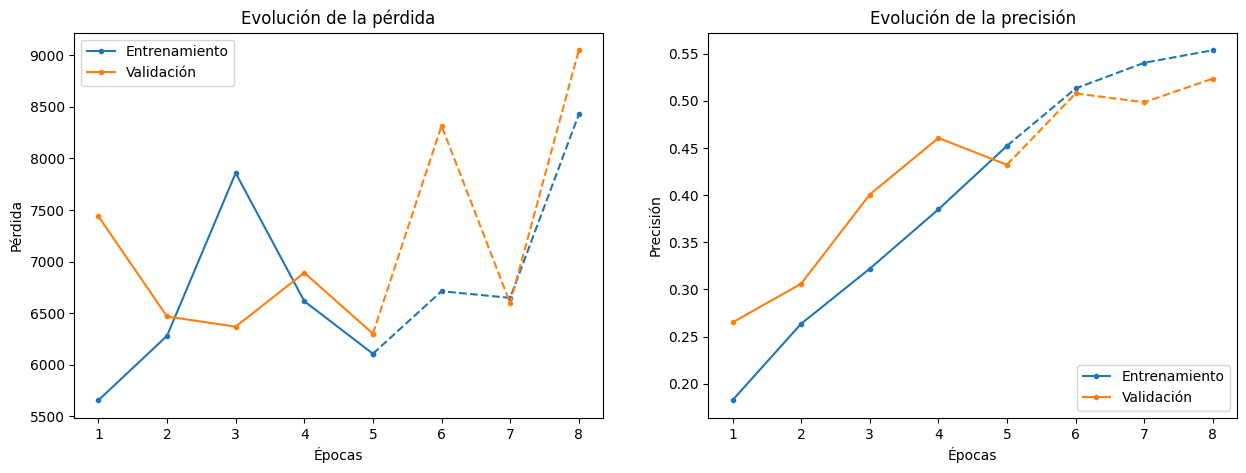

In [51]:
plot_history(history_acc, early_stop = es_acc)

De estas gráficas se deduce que el modelo anterior ha ofrecido un rendimiento global más sólido.

In [52]:
y_pred = make_prediction(vgg_tuned, test_set)

13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 670ms/step



Informe de clasificación
                        precision    recall  f1-score   support

        Alfred_Sisley       0.28      0.44      0.34        52
          Edgar_Degas       0.00      0.00      0.00       140
       Francisco_Goya       0.35      0.22      0.27        58
         Marc_Chagall       0.86      0.40      0.54        48
        Pablo_Picasso       0.29      0.82      0.43        88
         Paul_Gauguin       0.20      0.55      0.30        62
Pierre-Auguste_Renoir       0.46      0.51      0.48        67
            Rembrandt       0.86      0.48      0.62        52
               Titian       0.84      0.53      0.65        51
     Vincent_van_Gogh       0.94      0.54      0.68       175

             accuracy                           0.43       793
            macro avg       0.51      0.45      0.43       793
         weighted avg       0.50      0.43      0.42       793



/Users/adriandelpozo/Desktop/MSc_BIG_DATA/ANÁLISIS_DE_DATOS_NO_ESTRUCTURADOS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adriandelpozo/Desktop/MSc_BIG_DATA/ANÁLISIS_DE_DATOS_NO_ESTRUCTURADOS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adriandelpozo/Desktop/MSc_BIG_DATA/ANÁLISIS_DE_DATOS_NO_ESTRUCTURADOS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 

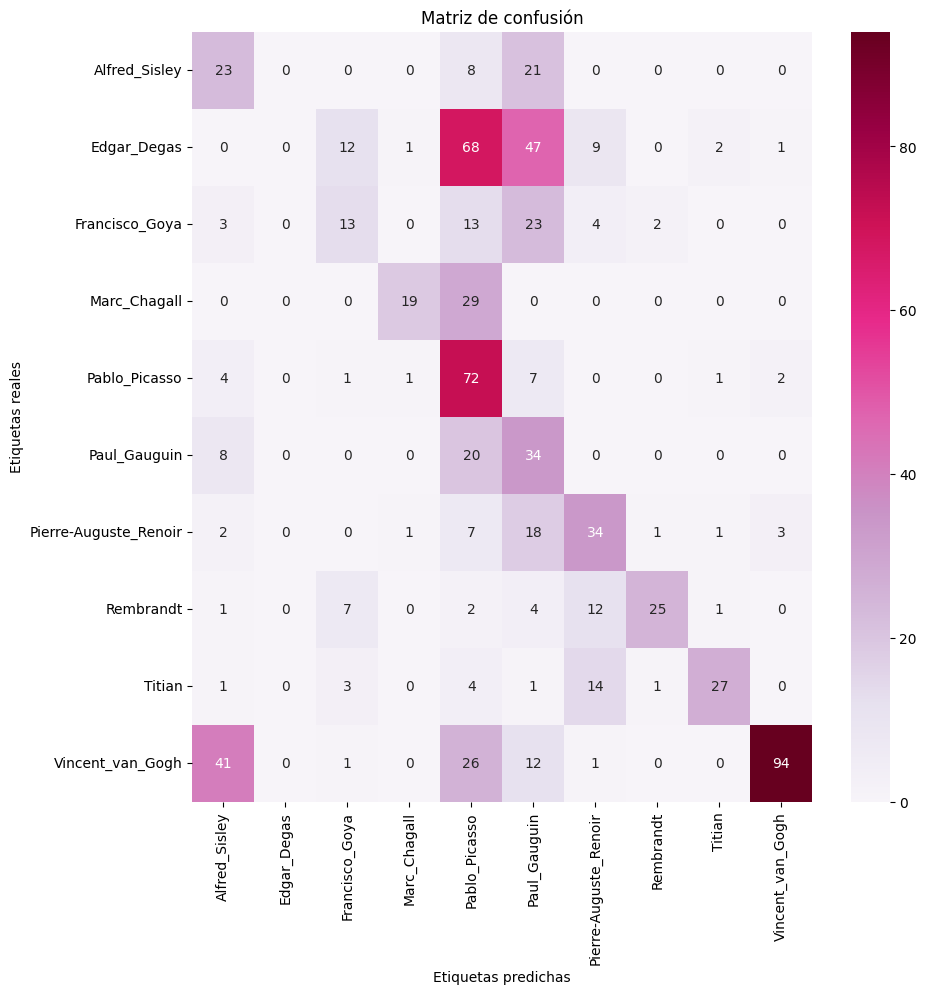

In [53]:
evaluate_prediction(vgg_tuned, y_test, y_pred, labels, plot_size=(10,10)) 

Aunque seguimos teniendo valores altos en la diagonal, también nos encontramos con valores altos fuera de ella. Es especialmente llamativo el caso de Edgar Degas. Mientras que clasificaba correctamente sus cuadros en el modelo anterio, con un total de 119, aquí bajamos hasta los 12, es decir, un descenso de 107 cuadros.

---
## 4.4. CONCLUSIÓN

Tras haber analizado y comparado todos el rendimiento de todos los modelos, se puede afirmar que aquel que mejores resultados nos ofrece es el 'vgg_optimized_trained.h5', obtenido a partir de *fine_tuning* sobre una arquitectura VGG16 haciendo en primer lugar una búsqueda de los hiperparámetros óptimos y pasando después a ajustar el modelo con esos hiperparámetros hallados.